In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [10]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [13]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Donchian Channel Test

In [493]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("r2_window",                     r2_window),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [495]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [497]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [499]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [501]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [503]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
    y_sum = y.rolling(r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
    y_sqr = (y**2).rolling(r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

    ## Calculate the R squared
    n = r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above 0.8 are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    return df

In [505]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    # z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
    #      slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())
    # Removing the Min Period, the Z-Score will be calculated when the mavg_z_score_window history is available
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).std())
    

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [507]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [509]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                                           use_activation=True, tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date

        df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=run_date, end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [14]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, 
                                                                entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window=4,
                                                                use_activation=True, tanh_activation_constant_dict=None,
                                                                moving_avg_type='exponential', long_only=False, price_or_returns_calc='price',
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                       entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                       use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc, 
                                                       use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [513]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Donchian Channel Breakout Parameter Optimization

In [12]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.9
donchian_signal_weight = 0.1
weighted_signal_ewm_window = 3
use_activation = False
tanh_activation_constant_dict = None
lower_r_sqr_limit = 0.30
upper_r_sqr_limit = 0.90
r2_window = 80
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
use_specific_start_date = True
signal_start_date = pd.Timestamp('2021-06-01').date()

In [518]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2023-12-31
warm_up_days                  : 285
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.9

entry_rolling_donchian_window : 28
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.1

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6

lower_r_sqr_limit   

In [42]:
start_date

datetime.date(2022, 4, 1)

In [94]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian\n",
## Stop Loss = 2.0 * ATR
# ticker_list_test = ['BTC-USD']
df_donchian_only = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [96]:
df_donchian_only = calculate_asset_level_returns(df_donchian_only, end_date=end_date, ticker_list=ticker_list)

In [98]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
perf.calculate_risk_and_performance_metrics(df_donchian_only, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.17308015206816862,
 'annualized_sharpe_ratio': 0.47164752542280275,
 'calmar_ratio': 0.295034601117698,
 'annualized_std_dev': 0.4986929601724622,
 'max_drawdown': -0.5866435713386777,
 'max_drawdown_duration': Timedelta('560 days 00:00:00'),
 'hit_rate': 0.40523690773067333,
 't_statistic': 0.8645958329383346,
 'p_value': 0.38751950536750024,
 'trade_count': 1920.0}

In [100]:
df_donchian_only.head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2021-10-21                      3029.173652                               0.0   
2021-10-22                      3178.857114                               0.0   
2021-10-23                      3233.251675                               0.0   
2021-10-24                      3125.322944                               0.0   
2021-10-25                      3015.203616                               0.0   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2021-10-21                           0.0                          0.654385   
2021-10-22                           0.0                          0.639165   
2021-10-23                           0.0                          0.651724   
2021-10-24                           0.0                          0.651816   
2021-10-25                           0.0                          0.656002   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2021-10-21                         0.0       62204.02   
2021-10-22                         0.0       60687.64   
2021-10-23                         0.0       61300.01   
2021-10-24                         0.0       60854.48   
2021-10-25                         0.0       63083.54   

            BTC-USD_cooldown_counter BTC-USD_event  BTC-USD_final_signal  \
date                                                                       
2021-10-21                       0.0             0              0.000000   
2021-10-22                       0.0             0              0.000000   
2021-10-23                       0.0             0              0.000000   
2021-10-24                       0.0             0              0.834317   
2021-10-25                       0.0             0              0.824136   

            BTC-USD_final_weighted_additive_signal  \
date                                                 
2021-10-21                                0.000000   
2021-10-22                                0.000000   
2021-10-23                                0.000000   
2021-10-24                                0.366955   
2021-10-25                                0.357003   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2021-10-21                                    0.0   
2021-10-22                                    0.0   
2021-10-23                                    0.0   
2021-10-24                                    0.0   
2021-10-25                                    0.0   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2021-10-21                            0.0                        0.0   
2021-10-22                            0.0                        0.0   
2021-10-23                            0.0                        0.0   
2021-10-24                            0.0                        0.0   
2021-10-25                            0.0                        0.0   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2021-10-21      66021.26                             0.0   
2021-10-22      62204.01                             0.0   
2021-10-23      60682.88                             0.0   
2021-10-24      61300.02                             0.0   
2021-10-25      60847.91                             0.0   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2021-10-21                         0.0                          0.0   
2021-10-22                         0.0                          0.0   
202

In [102]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
daily_pct_return_cols = [f'{ticker}_daily_pct_returns' for ticker in ticker_list]

<Axes: xlabel='date'>

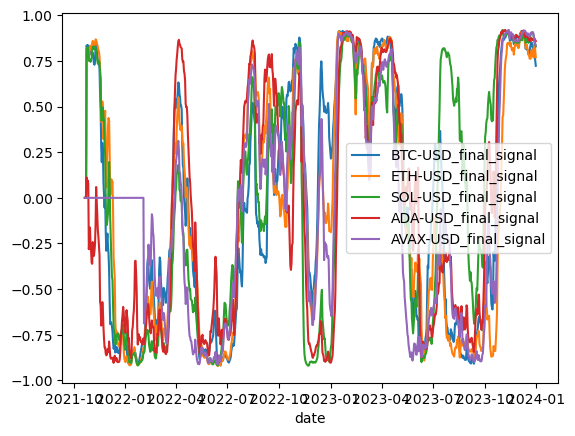

In [104]:
df_donchian_only[final_signal_cols].plot()

<Axes: xlabel='date'>

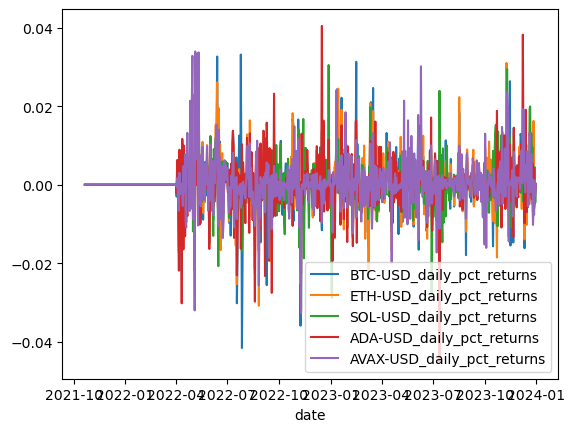

In [106]:
df_donchian_only[daily_pct_return_cols].plot()

<Axes: xlabel='date'>

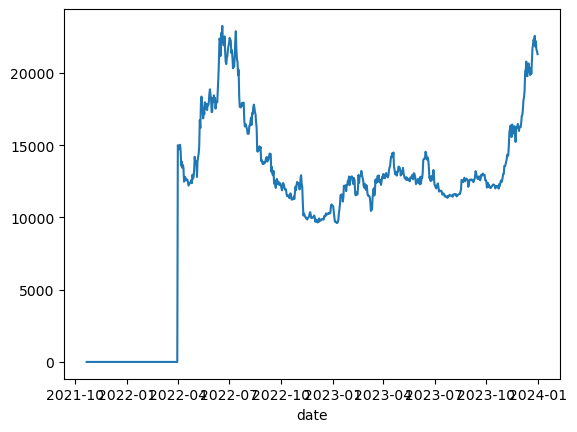

In [108]:
df_donchian_only['total_portfolio_value'].plot()

## Run-Walk Forward Analysis for Donchian Channels

In [42]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [10, 14, 20, 28, 40, 56],
        # "exit_window": [0.25, 0.5, 0.75, 1],
        # 'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [44]:
def run_walk_forward_donchian_ribbon(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date, ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_entry_window = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['entry_window'].iloc[0]
        print(f'Best In Sample Entry Window: {best_in_sample_entry_window}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=best_in_sample_entry_window, exit_rolling_donchian_window=exit_window, 
            use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)

        df_os = df_os[df_os.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

        ## In Sample Performance Metrics
        print('Getting In Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_is,
            'end_date': end_date_is,
            'entry_window': best_in_sample_entry_window,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [46]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-10-01').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    if end_date_os > last_available_date:
        print('end_date_os > last_available_date')
        end_date_os = last_available_date
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
    
    print("Run Dates: ")
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS s

In [49]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [136]:
%%time
df_performance_donchian_1 = run_walk_forward_donchian_ribbon(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [140]:
df_performance_donchian_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2024-04-01.pickle')

In [142]:
%%time
df_performance_donchian_2 = run_walk_forward_donchian_ribbon(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [144]:
df_performance_donchian_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-10-01-2024-10-01.pickle')

In [146]:
%%time
df_performance_donchian_3 = run_walk_forward_donchian_ribbon(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [147]:
df_performance_donchian_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2023-04-01-2025-04-01.pickle')

In [150]:
%%time
df_performance_donchian_4 = run_walk_forward_donchian_ribbon(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 14}
14 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [151]:
df_performance_donchian_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2023-10-01-2025-10-01.pickle')

In [154]:
df_performance_donchian = pd.concat([df_performance_donchian_1, df_performance_donchian_2, df_performance_donchian_3, df_performance_donchian_4], axis=0, ignore_index=True)

In [158]:
df_performance_donchian.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2025-10-01.pickle')

## Analyze Walk Forward Results for Donchian Channels

In [ ]:
# strategy_cols = df_perf[sharpe_col].columns.tolist()

In [48]:
def plot_donchian_channel_performance(df_perf, ticker_list, sharpe_col='annualized_sharpe_ratio'):

    fig = plt.figure(figsize=(15,10))
    layout = (1,1)
    signal_ax = plt.subplot2grid(layout, (0,0))
    # price_ax = signal_ax.twinx()
    # equity_curve_ax = plt.subplot2grid(layout, (0,1))
    # sharpe_ax = plt.subplot2grid(layout, (1,0))
    # portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    for col in df_perf[sharpe_col].columns:
        _ = signal_ax.plot(df_perf.index, df_perf[sharpe_col][col], label=col, alpha=0.9)

    _ = signal_ax.set_title(f'Donchian Strategy Performance')
    _ = signal_ax.set_ylabel('Sharpe Ratio')
    _ = signal_ax.set_xlabel('Strategy')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.tick_params(axis='x', labelrotation=90)
    _ = signal_ax.grid()

    plt.tight_layout()

    fig = plt.figure(figsize=(20,15))
    layout = (2,2)
    fold_1_ax = plt.subplot2grid(layout, (0,0))
    fold_2_ax = plt.subplot2grid(layout, (0,1))
    fold_3_ax = plt.subplot2grid(layout, (1,0))
    fold_4_ax = plt.subplot2grid(layout, (1,1))

    strategy_cols = df_perf[sharpe_col].columns.tolist()
    
    for ticker in ticker_list:
        ticker_col = f'{ticker}_annualized_sharpe_ratio'
        _ = fold_1_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[0]], label=ticker, alpha=0.9)
        _ = fold_2_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[1]], label=ticker, alpha=0.9)
        _ = fold_3_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[2]], label=ticker, alpha=0.9)
        _ = fold_4_ax.plot(df_perf.index, df_perf[ticker_col][strategy_cols[3]], label=ticker, alpha=0.9)

    _ = fold_1_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[0]}')
    _ = fold_1_ax.set_ylabel('Sharpe Ratio')
    _ = fold_1_ax.set_xlabel('Strategy')
    _ = fold_1_ax.legend(loc='upper left', ncols=3)
    _ = fold_1_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_1_ax.grid()

    _ = fold_2_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[1]}')
    _ = fold_2_ax.set_ylabel('Sharpe Ratio')
    _ = fold_2_ax.set_xlabel('Strategy')
    _ = fold_2_ax.legend(loc='upper left', ncols=3)
    _ = fold_2_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_2_ax.grid()

    _ = fold_3_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[2]}')
    _ = fold_3_ax.set_ylabel('Sharpe Ratio')
    _ = fold_3_ax.set_xlabel('Strategy')
    _ = fold_3_ax.legend(loc='upper left', ncols=3)
    _ = fold_3_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_3_ax.grid()

    _ = fold_4_ax.set_title(f'Donchian Strategy Performance - {ticker} - {strategy_cols[3]}')
    _ = fold_4_ax.set_ylabel('Sharpe Ratio')
    _ = fold_4_ax.set_xlabel('Strategy')
    _ = fold_4_ax.legend(loc='upper left', ncols=3)
    _ = fold_4_ax.tick_params(axis='x', labelrotation=90)
    _ = fold_4_ax.grid()

    plt.tight_layout()

    return

In [50]:
df_performance_donchian = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Performance-2022-04-01-2025-10-01.pickle')

In [52]:
out_of_sample_cond = (df_performance_donchian['sampling_category'] == 'out_sample')
df_performance_donchian_os = df_performance_donchian[out_of_sample_cond]
df_performance_donchian_is = df_performance_donchian[~out_of_sample_cond]

In [54]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
df_performance_donchian_is.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
10                          1.252823  0.957475  0.812336          0.672941   
14                          1.250954  0.971353  0.718448          0.671312   
20                          1.233180  0.931848  0.721452          0.658009   
28                          1.195184  0.893429  0.666712          0.629803   
40                          1.242642  0.936693  0.688921          0.668032   
56                          1.244409  0.924160  0.766121          0.670977   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
10            0.552325  0.514787    -0.293417 -0.347717  0.170922   
14            0.545274  0.458344    -0.296009 -0.347527  0.164812   
20            0.513965  0.443851    -0.298718 -0.352725  0.165888   
28            0.476911  0.402329    -0.300968 -0.353111  0.165827   
40            0.510713  0.424946    -0.291610 -0.351675  0.162659   
56            0.515159  0.471848    -0.293228 -0.355586  0.165382   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.452902  0.501482  0.574258   
14                                  0.384959  0.429228  0.572986   
20                                  0.299556  0.350163  0.585677   
28                                  0.072552  0.191244  0.541916   
40                                  0.058653  0.168711  0.567829   
56                                  0.072891  0.177773  0.579519   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.568042  0.463805  0.590903   
14                                  0.396565  0.395435  0.501300   
20                                  0.262464  0.278879  0.431202   
28                                  0.269183  0.366845  0.380954   
40                                  0.504937  0.439102  0.450914   
56                                  0.640985  0.528232  0.545706   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.268856  0.067038  0.456488   
14                                  0.303210  0.137320  0.430358   
20                                  0.373493  0.154560  0.539295   
28                                  0.358403  0.117924  0.588379   
40                                  0.178255  0.062698  0.493870   
56                                  0.100148 -0.050045  0.551886   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.687183  0.296410  1.085071   
14                                  0.779230  0.405000  1.049100   
20                                  0.759948  0.405500  1.037998   
28                                  0.595538  0.274150  0.960808   
40                                  0.617103  0.280336  0.905117   
56                                  0.658196  0.306536  0.927952   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                              

In [56]:
df_performance_donchian_os.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                    annualized_return  \
                              median      mean      std            median   
entry_window                                                                
10                         -0.445712 -0.445712  2.58356          0.106397   
40                          2.603239  2.603239      NaN          2.420425   
56                          0.065850  0.065850      NaN         -0.036367   

                                 max_drawdown                     \
                  mean       std       median      mean      std   
entry_window                                                       
10            0.106397  1.096412    -0.317497 -0.317497  0.05662   
40            2.420425       NaN    -0.221524 -0.221524      NaN   
56           -0.036367       NaN    -0.203298 -0.203298      NaN   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.117844 -0.117844  1.882238   
40                                  0.700044  0.700044       NaN   
56                                 -1.229670 -1.229670       NaN   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.795006 -0.795006  1.120239   
40                                  1.504468  1.504468       NaN   
56                                 -0.657546 -0.657546       NaN   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -2.069682 -2.069682  1.996286   
40                                  2.909615  2.909615       NaN   
56                                 -1.475761 -1.475761       NaN   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.234943 -0.234943  1.211666   
40                                  1.973438  1.973438       NaN   
56                                  1.163847  1.163847       NaN   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                                  -0.967414 -0.967414  3.986596  
40                                   2.203500  2.203500       NaN  
56                                   0.556059  0.556059       NaN

In [58]:
df_performance_donchian_os.groupby(['entry_window','start_date']).agg(agg_dict)

annualized_sharpe_ratio                \
                                         median      mean std   
entry_window start_date                                         
10           2023-04-01                1.381141  1.381141 NaN   
             2023-10-01               -2.272565 -2.272565 NaN   
40           2022-04-01                2.603239  2.603239 NaN   
56           2022-10-01                0.065850  0.065850 NaN   

                        annualized_return               max_drawdown  \
                                   median      mean std       median   
entry_window start_date                                                
10           2023-04-01          0.881678  0.881678 NaN    -0.277461   
             2023-10-01         -0.668883 -0.668883 NaN    -0.357534   
40           2022-04-01          2.420425  2.420425 NaN    -0.221524   
56           2022-10-01         -0.036367 -0.036367 NaN    -0.203298   

                                      BTC-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.277461 NaN                        1.213100   
             2023-10-01 -0.357534 NaN                       -1.448787   
40           2022-04-01 -0.221524 NaN                        0.700044   
56           2022-10-01 -0.203298 NaN                       -1.229670   

                                      ETH-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01  1.213100 NaN                       -0.002877   
             2023-10-01 -1.448787 NaN                       -1.587134   
40           2022-04-01  0.700044 NaN                        1.504468   
56           2022-10-01 -1.229670 NaN                       -0.657546   

                                      SOL-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.002877 NaN                       -0.658095   
             2023-10-01 -1.587134 NaN                       -3.481270   
40           2022-04-01  1.504468 NaN                        2.909615   
56           2022-10-01 -0.657546 NaN                       -1.475761   

                                      ADA-USD_annualized_sharpe_ratio  \
                             mean std                          median   
entry_window start_date                                                 
10           2023-04-01 -0.658095 NaN                        0.621835   
             2023-10-01 -3.481270 NaN                       -1.091720   
40           2022-04-01  2.909615 NaN                        1.973438   
56           2022-10-01 -1.475761 NaN                        1.163847   

                                      AVAX-USD_annualized_sharpe_ratio  \
                             mean std                           median   
entry_window start_date                                                  
10           2023-04-01  0.621835 NaN                         1.851535   
             2023-10-01 -1.091720 NaN                        -3.786363   
40           2022-04-01  1.973438 NaN                         2.203500   
56           2022-10-01  1.163847 NaN                         0.556059   

                                       
                             mean std  
entry_window start_date                
10           2023-04-01  1.851535 NaN  
             2023-10-01 -3.786363 NaN  
40           2022-04-01  2.203500 NaN  
56           2022-10-01  0.556059 NaN

In [60]:
df_performance_donchian_os.groupby(['start_date','end_date','entry_window']).agg(agg_dict)

annualized_sharpe_ratio                \
                                                    median      mean std   
start_date end_date   entry_window                                         
2022-04-01 2023-09-30 40                          2.603239  2.603239 NaN   
2022-10-01 2024-03-31 56                          0.065850  0.065850 NaN   
2023-04-01 2024-09-30 10                          1.381141  1.381141 NaN   
2023-10-01 2025-03-31 10                         -2.272565 -2.272565 NaN   

                                   annualized_return                \
                                              median      mean std   
start_date end_date   entry_window                                   
2022-04-01 2023-09-30 40                    2.420425  2.420425 NaN   
2022-10-01 2024-03-31 56                   -0.036367 -0.036367 NaN   
2023-04-01 2024-09-30 10                    0.881678  0.881678 NaN   
2023-10-01 2025-03-31 10                   -0.668883 -0.668883 NaN   

                                   max_drawdown                \
                                         median      mean std   
start_date end_date   entry_window                              
2022-04-01 2023-09-30 40              -0.221524 -0.221524 NaN   
2022-10-01 2024-03-31 56              -0.203298 -0.203298 NaN   
2023-04-01 2024-09-30 10              -0.277461 -0.277461 NaN   
2023-10-01 2025-03-31 10              -0.357534 -0.357534 NaN   

                                   BTC-USD_annualized_sharpe_ratio            \
                                                            median      mean   
start_date end_date   entry_window                                             
2022-04-01 2023-09-30 40                                  0.700044  0.700044   
2022-10-01 2024-03-31 56                                 -1.229670 -1.229670   
2023-04-01 2024-09-30 10                                  1.213100  1.213100   
2023-10-01 2025-03-31 10                                 -1.448787 -1.448787   

                                       ETH-USD_annualized_sharpe_ratio  \
                                   std                          median   
start_date end_date   entry_window                                       
2022-04-01 2023-09-30 40           NaN                        1.504468   
2022-10-01 2024-03-31 56           NaN                       -0.657546   
2023-04-01 2024-09-30 10           NaN                       -0.002877   
2023-10-01 2025-03-31 10           NaN                       -1.587134   

                                                  \
                                        mean std   
start_date end_date   entry_window                 
2022-04-01 2023-09-30 40            1.504468 NaN   
2022-10-01 2024-03-31 56           -0.657546 NaN   
2023-04-01 2024-09-30 10           -0.002877 NaN   
2023-10-01 2025-03-31 10           -1.587134 NaN   

                                   SOL-USD_annualized_sharpe_ratio            \
                                                            median      mean   
start_date end_date   entry_window                                             
2022-04-01 2023-09-30 40                                  2.909615  2.909615   
2022-10-01 2024-03-31 56                                 -1.475761 -1.475761   
2023-04-01 2024-09-30 10                                 -0.658095 -0.658095   
2023-10-01 2025-03-31 10                                 -3.481270 -3.481270   

                                       ADA-USD_annualized_sharpe_ratio  \
                                   std                          median   
start_date end_date   entry_window                                       
2022-04-01 2023-09-30 40           NaN                        1.973438   
2022-10-01 2024-03-31 56           NaN                        1.163847   
2023-04-01 2024-09-30 10           NaN                        0.621835   
2023-10-01 2025-03-31 10           NaN                       -1.091720   

                              

In [62]:
df_performance_donchian

sampling_category  start_date    end_date  entry_window  exit_window  \
0          in_sample  2022-04-01  2023-09-30            10           28   
1          in_sample  2022-04-01  2023-09-30            14           28   
2          in_sample  2022-04-01  2023-09-30            20           28   
3          in_sample  2022-04-01  2023-09-30            28           28   
4          in_sample  2022-04-01  2023-09-30            40           28   
5          in_sample  2022-04-01  2023-09-30            56           28   
6         out_sample  2022-04-01  2023-09-30            40           28   
7          in_sample  2022-10-01  2024-03-31            10           28   
8          in_sample  2022-10-01  2024-03-31            14           28   
9          in_sample  2022-10-01  2024-03-31            20           28   
10         in_sample  2022-10-01  2024-03-31            28           28   
11         in_sample  2022-10-01  2024-03-31            40           28   
12         in_sample  2022-10-01  2024-03-31            56           28   
13        out_sample  2022-10-01  2024-03-31            56           28   
14         in_sample  2023-04-01  2024-09-30            10           28   
15         in_sample  2023-04-01  2024-09-30            14           28   
16         in_sample  2023-04-01  2024-09-30            20           28   
17         in_sample  2023-04-01  2024-09-30            28           28   
18         in_sample  2023-04-01  2024-09-30            40           28   
19         in_sample  2023-04-01  2024-09-30            56           28   
20        out_sample  2023-04-01  2024-09-30            10           28   
21         in_sample  2023-10-01  2025-03-31            10           28   
22         in_sample  2023-10-01  2025-03-31            14           28   
23         in_sample  2023-10-01  2025-03-31            20           28   
24         in_sample  2023-10-01  2025-03-31            28           28   
25         in_sample  2023-10-01  2025-03-31            40           28   
26         in_sample  2023-10-01  2025-03-31            56           28   
27        out_sample  2023-10-01  2025-03-31            10           28   

    exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0       False          -0.175161                -0.240724     -0.294243   
1       False          -0.111736                -0.092657     -0.191499   
2       False          -0.133842                -0.143245     -0.226071   
3       False          -0.117767                -0.103282     -0.199837   
4       False          -0.111868                -0.088153     -0.190202   
5       False          -0.168686                -0.211598     -0.282452   
6       False           2.420425                 2.603239     10.926252   
7       False           0.683936                 1.268078      2.537095   
8       False           0.708945                 1.301933      2.744428   
9       False           0.673241                 1.253906      2.536225   
10      False           0.659391                 1.236189      2.565561   
11      False           0.738039                 1.331497      2.895781   
12      False           0.752152                 1.345604      2.893836   
13      False          -0.036367                 0.065850     -0.178883   
14      False           0.661945                 1.237568      3.171148   
15      False           0.633680                 1.199974      2.952685   
16      False           0.642776                 1.212455      2.902874   
17      False           0.600216                 1.154179      2.713529   
18      False           0.598025                 1.153786      2.541257   
19      False           0.589801                 1.143213      2.471229   
20      False           0.881678                 1.381141      3.177670   
21      False           1.038579                 1.564978      3.273606   
22      False           0.950209                 1.476162      2.847530   
23      False           0.8

## Re-Run Walk Forward for every Window In and Out of Sample to Create an Ensemble

In [67]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [10, 14, 20, 28, 40, 56],
        # "exit_window": [0.25, 0.5, 0.75, 1],
        # 'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [64]:
def run_walk_forward_donchian_ribbon_all(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date, ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            ## Out of Sample Dataframe
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
    
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)
    
            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [66]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-10-01').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(months=18)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
last_available_date = pd.Timestamp('2025-07-31').date()
WARMUP_DAYS = 323
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    fmt = "%Y-%m-%d"
    
    fields = [
        ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
        ("IS start",          start_date_is),
        ("IS end",            end_date_is),
        ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
        ("OS start",          start_date_os),
        ("OS end",            end_date_os),
    ]
    
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date - pd.Timedelta(days=1):
        break

    if end_date_os > last_available_date:
        print('end_date_os > last_available_date')
        end_date_os = last_available_date
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
    
    print("Run Dates: ")
    print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
    start_date_is = (start_date_is + OS_LEN).date()

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS s

In [199]:
%%time
df_performance_donchian_all_1 = run_walk_forward_donchian_ribbon_all(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [200]:
df_performance_donchian_all_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2024-04-01.pickle')

In [201]:
%%time
df_performance_donchian_all_2 = run_walk_forward_donchian_ribbon_all(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [202]:
df_performance_donchian_all_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-10-01-2024-10-01.pickle')

In [203]:
%%time
df_performance_donchian_all_3 = run_walk_forward_donchian_ribbon_all(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calcu

In [204]:
df_performance_donchian_all_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-04-01-2025-04-01.pickle')

In [205]:
%%time
df_performance_donchian_all_4 = run_walk_forward_donchian_ribbon_all(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 10}
10 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calcula

In [149]:
df_performance_donchian_all_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-10-01-2025-10-01.pickle')

In [68]:
df_performance_donchian_all_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2024-04-01.pickle')
df_performance_donchian_all_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-10-01-2024-10-01.pickle')
df_performance_donchian_all_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-04-01-2025-04-01.pickle')
df_performance_donchian_all_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2023-10-01-2025-10-01.pickle')

In [70]:
df_performance_donchian_all = pd.concat([df_performance_donchian_all_1,df_performance_donchian_all_2,df_performance_donchian_all_3,df_performance_donchian_all_4], axis=0, ignore_index=True)

In [77]:
df_performance_donchian_all.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_All_Performance-2022-04-01-2025-10-01.pickle')

In [72]:
df_performance_donchian_all_is = df_performance_donchian_all[df_performance_donchian_all.sampling_category == 'in_sample']
df_performance_donchian_all_os = df_performance_donchian_all[df_performance_donchian_all.sampling_category == 'out_sample']

In [74]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
df_performance_donchian_all.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
10                          1.252823  0.782109  1.593527          0.672941   
14                          1.250954  0.792581  1.474341          0.671312   
20                          1.210006  0.757998  1.403480          0.658009   
28                          1.169966  0.801417  1.117901          0.629803   
40                          1.162193  0.818928  1.132217          0.634518   
56                          1.244409  0.850102  1.097930          0.670977   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
10            0.742290  1.260399    -0.273518 -0.300313  0.134381   
14            0.699251  1.145106    -0.275798 -0.301015  0.128959   
20            0.636705  1.046472    -0.273450 -0.303504  0.126495   
28            0.572734  0.859634    -0.257695 -0.299302  0.126074   
40            0.589063  0.869743    -0.256195 -0.301160  0.123860   
56            0.606110  0.841853    -0.252952 -0.298623  0.126388   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.452902  0.291492  1.196489   
14                                  0.384959  0.285563  1.097809   
20                                  0.299556  0.229750  1.061641   
28                                  0.072552  0.153617  0.809737   
40                                  0.058653  0.086538  0.834858   
56                                  0.072891  0.123636  0.828912   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.241585  0.213968  1.171787   
14                                  0.091136  0.139338  1.068254   
20                                  0.012979  0.050211  0.855925   
28                                  0.127460  0.157743  0.712922   
40                                  0.276515  0.173990  0.908037   
56                                  0.498989  0.269384  0.970571   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                 -0.176426 -0.277993  1.653742   
14                                 -0.130797 -0.251228  1.648337   
20                                 -0.191185 -0.082270  1.451871   
28                                 -0.243713  0.061547  1.318982   
40                                 -0.286075 -0.073698  1.407017   
56                                 -0.421116 -0.116543  1.445299   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
10                                  0.786239  0.523077  1.194273   
14                                  0.957751  0.646766  1.130853   
20                                  0.995026  0.667532  1.107238   
28                                  0.887155  0.528539  1.015003   
40                                  0.617103  0.491138  0.956785   
56                                  0.664430  0.491744  0.937873   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
10                              

In [76]:
df_performance_donchian_all_is.groupby(['entry_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
14                          1.250954  0.971353  0.718448          0.671312   
10                          1.252823  0.957475  0.812336          0.672941   
40                          1.242642  0.936693  0.688921          0.668032   
20                          1.233180  0.931848  0.721452          0.658009   
56                          1.244409  0.924160  0.766121          0.670977   
28                          1.195184  0.893429  0.666712          0.629803   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
14            0.545274  0.458344    -0.296009 -0.347527  0.164812   
10            0.552325  0.514787    -0.293417 -0.347717  0.170922   
40            0.510713  0.424946    -0.291610 -0.351675  0.162659   
20            0.513965  0.443851    -0.298718 -0.352725  0.165888   
56            0.515159  0.471848    -0.293228 -0.355586  0.165382   
28            0.476911  0.402329    -0.300968 -0.353111  0.165827   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.384959  0.429228  0.572986   
10                                  0.452902  0.501482  0.574258   
40                                  0.058653  0.168711  0.567829   
20                                  0.299556  0.350163  0.585677   
56                                  0.072891  0.177773  0.579519   
28                                  0.072552  0.191244  0.541916   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.396565  0.395435  0.501300   
10                                  0.568042  0.463805  0.590903   
40                                  0.504937  0.439102  0.450914   
20                                  0.262464  0.278879  0.431202   
56                                  0.640985  0.528232  0.545706   
28                                  0.269183  0.366845  0.380954   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.303210  0.137320  0.430358   
10                                  0.268856  0.067038  0.456488   
40                                  0.178255  0.062698  0.493870   
20                                  0.373493  0.154560  0.539295   
56                                  0.100148 -0.050045  0.551886   
28                                  0.358403  0.117924  0.588379   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
14                                  0.779230  0.405000  1.049100   
10                                  0.687183  0.296410  1.085071   
40                                  0.617103  0.280336  0.905117   
20                                  0.759948  0.405500  1.037998   
56                                  0.658196  0.306536  0.927952   
28                                  0.595538  0.274150  0.960808   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
14                              

In [78]:
df_performance_donchian_all_os.groupby(['entry_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
56                          0.732911  0.776045  1.486994          0.426187   
28                          0.673337  0.709404  1.564893          0.346673   
40                          0.656912  0.701163  1.574655          0.335189   
14                          0.758556  0.613809  2.114362          0.426320   
10                          0.774836  0.606743  2.276664          0.446236   
20                          0.704453  0.584148  1.998752          0.366617   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
56            0.697060  1.187002    -0.237600 -0.241659  0.035617   
28            0.668557  1.240126    -0.236759 -0.245493  0.043217   
40            0.667413  1.252241    -0.239524 -0.250645  0.050334   
14            0.853227  1.669229    -0.249806 -0.254502  0.076630   
10            0.932256  1.829074    -0.243473 -0.252910  0.083242   
20            0.759446  1.522519    -0.245724 -0.254283  0.057934   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                  0.071048  0.069500  1.122304   
28                                  0.299533  0.115991  1.110160   
40                                  0.095981  0.004366  1.133962   
14                                  0.042679  0.141898  1.558443   
10                                 -0.041794  0.081503  1.700884   
20                                  0.011193  0.109337  1.499392   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                 -0.097159  0.010535  1.312079   
28                                 -0.341775 -0.051360  0.961359   
40                                 -0.220902 -0.091123  1.238208   
14                                 -0.499775 -0.116760  1.495502   
10                                 -0.390193 -0.035869  1.639588   
20                                 -0.526291 -0.178456  1.176455   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                 -1.132974 -0.183041  2.134878   
28                                 -0.883117  0.005170  1.924750   
40                                 -1.242423 -0.210094  2.079850   
14                                 -0.917896 -0.639776  2.398313   
10                                 -0.724238 -0.623024  2.419816   
20                                 -1.023703 -0.319100  2.116151   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
56                                  0.827953  0.676953  1.048737   
28                                  0.960400  0.782928  1.143744   
40                                  0.729338  0.701941  1.094661   
14                                  1.000924  0.888531  1.314327   
10                                  0.883540  0.749744  1.419019   
20                                  1.122216  0.929564  1.264941   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
56                              

In [87]:
df_performance_donchian_all_os#.groupby(['start_date'])[['start_date','annualized_sharpe_ratio']]#.mean()#.sort_values('entry_window').reset_index(drop=True)

sampling_category  start_date    end_date  entry_window  exit_window  \
1         out_sample  2022-04-01  2023-09-30            10           28   
3         out_sample  2022-04-01  2023-09-30            14           28   
5         out_sample  2022-04-01  2023-09-30            20           28   
7         out_sample  2022-04-01  2023-09-30            28           28   
9         out_sample  2022-04-01  2023-09-30            40           28   
11        out_sample  2022-04-01  2023-09-30            56           28   
13        out_sample  2022-10-01  2024-03-31            10           28   
15        out_sample  2022-10-01  2024-03-31            14           28   
17        out_sample  2022-10-01  2024-03-31            20           28   
19        out_sample  2022-10-01  2024-03-31            28           28   
21        out_sample  2022-10-01  2024-03-31            40           28   
23        out_sample  2022-10-01  2024-03-31            56           28   
25        out_sample  2023-04-01  2024-09-30            10           28   
27        out_sample  2023-04-01  2024-09-30            14           28   
29        out_sample  2023-04-01  2024-09-30            20           28   
31        out_sample  2023-04-01  2024-09-30            28           28   
33        out_sample  2023-04-01  2024-09-30            40           28   
35        out_sample  2023-04-01  2024-09-30            56           28   
37        out_sample  2023-10-01  2025-03-31            10           28   
39        out_sample  2023-10-01  2025-03-31            14           28   
41        out_sample  2023-10-01  2025-03-31            20           28   
43        out_sample  2023-10-01  2025-03-31            28           28   
45        out_sample  2023-10-01  2025-03-31            40           28   
47        out_sample  2023-10-01  2025-03-31            56           28   

    exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
1       False           3.505433                 3.149864     20.970496   
3       False           3.190738                 2.986645     18.099947   
5       False           2.899687                 2.853497     14.302012   
7       False           2.398929                 2.591592     11.150379   
9       False           2.420425                 2.603239     10.926252   
11      False           2.291851                 2.512706      9.998852   
13      False           0.010795                 0.168531      0.051530   
15      False           0.020640                 0.187889      0.100030   
17      False           0.027473                 0.201349      0.130826   
19      False           0.006365                 0.160921      0.030670   
21      False          -0.000633                 0.143223     -0.003091   
23      False          -0.036367                 0.065850     -0.178883   
25      False           0.881678                 1.381141      3.177670   
27      False           0.832001                 1.329224      2.836941   
29      False           0.705760                 1.207558      2.507581   
31      False           0.686982                 1.185754      2.282816   
33      False           0.671011                 1.170600      2.106183   
35      False           0.888740                 1.399972      3.084408   
37      False          -0.668883                -2.272565     -1.870824   
39      False          -0.630471                -2.048522     -1.842877   
41      False          -0.595137                -1.925813     -1.842875   
43      False          -0.418049                -1.100650     -1.617999   
45      False          -0.421152                -1.112412     -1.635394   
47      False          -0.355984                -0.874348     -1.447164   

    annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
1             0.506589     -0.167160               54 days  0.551913   
3             0.517073     -0.176284               63 days  0.546448   
5             0.509779     -0.20274

## Test Ensemble Donchian Signal

In [80]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'high'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'low'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [82]:
## Original Signal
def generate_trend_signal_with_donchian_channel_ensemble_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window_list, 
                                                                    exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                                    use_activation=True, tanh_activation_constant_dict=None, 
                                                                    moving_avg_type='exponential', price_or_returns_calc='price',
                                                                    long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    # donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    # donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    donchian_ensemble_signal_rank_col = f'{ticker}_donchian_ensemble_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    # donchian_ensemble_windows = [28, 40, 56]
    donchian_dfs = []
    for entry_window in donchian_ensemble_windows:
        
        df_ensemble = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                             entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                             use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
    
        t_1_close_col = f't_1_close'
        df_ensemble[t_1_close_col] = df_ensemble[f'close'].shift(1)
        donchian_entry_upper_band_col = f'{ticker}_{entry_window}_donchian_entry_upper_band_{price_or_returns_calc}'
        donchian_entry_lower_band_col = f'{ticker}_{entry_window}_donchian_entry_lower_band_{price_or_returns_calc}'
        donchian_entry_middle_band_col = f'{ticker}_{entry_window}_donchian_entry_middle_band_{price_or_returns_calc}'
        donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
        donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
        donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal_{entry_window}'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_{entry_window}_rank'
        shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                      donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
        for col in shift_cols:
            df_ensemble[f'{col}_t_2'] = df_ensemble[col].shift(1)
    
        # Donchian Continuous Signal
        df_ensemble[donchian_continuous_signal_col] = ((df_ensemble[t_1_close_col] - df_ensemble[f'{donchian_entry_middle_band_col}_t_2']) /
                                                       (df_ensemble[f'{donchian_entry_upper_band_col}_t_2'] - df_ensemble[f'{donchian_entry_lower_band_col}_t_2']))
    
        ## Calculate Donchian Channel Rank
        ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
        ## slope near the origin takes into account even little information
        df_ensemble[donchian_continuous_signal_rank_col] = pct_rank(df_ensemble[donchian_continuous_signal_col]) - 0.5
        donchian_ensemble_cols = [donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
        donchian_dfs.append(df_ensemble[donchian_ensemble_cols])

    df_donchian = pd.concat(donchian_dfs, axis=1)
    donchian_exit_cols = [f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2', t_1_close_col]
    df_donchian = pd.merge(df_donchian, df_ensemble[donchian_exit_cols], left_index=True, right_index=True, how='left')
    donchian_signals_list = [f'{ticker}_donchian_continuous_signal_{window}_rank' for window in donchian_ensemble_windows]
    df_donchian[donchian_ensemble_signal_rank_col] = df_donchian[donchian_signals_list].mean(axis=1)

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_ensemble_signal_rank_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_ensemble_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_ensemble_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_ensemble_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_ensemble_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        print('Use Activation Function')
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_ensemble_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, entry_rolling_donchian_window_list, 
                                                     exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                                     use_activation=True, tanh_activation_constant_dict=None, 
                                                     long_only=False, price_or_returns_calc='price',
                                                     use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_ensemble_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window_list=entry_rolling_donchian_window_list, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_ensemble_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                mavg_z_score_window=mavg_z_score_window,
                entry_rolling_donchian_window_list=entry_rolling_donchian_window_list, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [84]:
def apply_target_volatility_position_sizing_continuous_ensemble_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window, ma_crossover_signal_weight,
                                                                         donchian_signal_weight, entry_rolling_donchian_window_list, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                         use_activation=True, tanh_activation_constant_dict=None, long_only=False,
                                                                         initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                         rolling_atr_window=20, atr_multiplier=0.5,
                                                                         transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                         use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                         rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                         annual_trading_days=365, use_specific_start_date=False,
                                                                         signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_ensemble_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                                                                entry_rolling_donchian_window_list=entry_rolling_donchian_window_list, 
                                                                exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                                long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [86]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2022-04-01
end_date                      : 2025-10-01
warm_up_days                  : 323
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 20
slow_mavg                     : 200
mavg_stepsize                 : 8
mavg_z_score_window           : 126
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.6

entry_rolling_donchian_window : 28
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.4

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
log_std_window                : 14
coef_of_variation_window      : 30
vol_of_vol_z_score_window     : 252
vol_of_vol_p_min              : 0.6

lower_r_sqr_limit   

In [88]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian\n",
## Stop Loss = 2.0 * ATR
# ticker_list_test = ['BTC-USD']
donchian_ensemble_windows = [28, 40, 56]
df_donchian_ensemble_only = apply_target_volatility_position_sizing_continuous_ensemble_strategy(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window_list=donchian_ensemble_windows, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    use_donchian_exit_gate=use_donchian_exit_gate, use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)

df_donchian_ensemble_only = calculate_asset_level_returns(df_donchian_ensemble_only, end_date=end_date, ticker_list=ticker_list)

## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
perf.calculate_risk_and_performance_metrics(df_donchian_ensemble_only, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


{'annualized_return': -0.0404165717306425,
 'annualized_sharpe_ratio': -0.01905860921902818,
 'calmar_ratio': -0.06402105910585831,
 'annualized_std_dev': 0.5578680853150114,
 'max_drawdown': -0.6313012045585504,
 'max_drawdown_duration': Timedelta('693 days 00:00:00'),
 'hit_rate': 0.2853965900667161,
 't_statistic': 0.19454617964742438,
 'p_value': 0.8457775550414228,
 'trade_count': 1759.0}

In [89]:
df_donchian_ensemble_only.head().T

date                                            2021-10-21         2021-10-22  \
BTC-USD_20_avg_true_range_price                3029.174462        3178.857846   
BTC-USD_actual_position_notional                       0.0                0.0   
BTC-USD_actual_position_size                           0.0                0.0   
BTC-USD_annualized_volatility_20                  0.654385           0.639165   
BTC-USD_cash_shrink_factor                             0.0                0.0   
BTC-USD_close                                     62204.02           60687.64   
BTC-USD_cooldown_counter                               0.0                0.0   
BTC-USD_event                                            0                  0   
BTC-USD_final_signal                              0.452733           0.407244   
BTC-USD_final_weighted_additive_signal            0.452733           0.407244   
BTC-USD_new_position_entry_exit_price                  0.0                0.0   
BTC-USD_new_position_notional                          0.0                0.0   
BTC-USD_new_position_size                              0.0                0.0   
BTC-USD_open                                      66021.26           62204.01   
BTC-USD_open_position_notional                         0.0                0.0   
BTC-USD_open_position_size                             0.0                0.0   
BTC-USD_short_sale_proceeds                            0.0                0.0   
BTC-USD_stop_loss                                      0.0                0.0   
BTC-USD_stopout_flag                                 False              False   
BTC-USD_t_1_close                                 66026.54           62204.02   
BTC-USD_t_1_close_pct_returns                     0.026801          -0.057894   
BTC-USD_target_notional                                0.0                0.0   
BTC-USD_target_size                                    0.0                0.0   
BTC-USD_target_vol_normalized_weight                   0.0                0.0   
BTC-USD_vol_adjusted_trend_signal                 0.691845           0.637151   
ETH-USD_20_avg_true_range_price                 221.734566         235.353178   
ETH-USD_actual_position_notional                       0.0                0.0   
ETH-USD_actual_position_size                           0.0                0.0   
ETH-USD_annualized_volatility_20                  0.659432           0.557233   
ETH-USD_cash_shrink_factor                             0.0                0.0   
ETH-USD_close                                       4053.9            3971.55   
ETH-USD_cooldown_counter                               0.0                0.0   
ETH-USD_event                                            0                  0   
ETH-USD_final_signal                              0.392077           0.388676   
ETH-USD_final_weighted_additive_signal            0.392077           0.388676   
ETH-USD_new_position_entry_exit_price                  0.0                0.0   
ETH-USD_new_position_notional                          0.0                0.0   
ETH-USD_new_position_size                              0.0                0.0   
ETH-USD_open                                       4161.83            4053.97   
ETH-USD_open_position_notional                         0.0                0.0   
ETH-USD_open_position_size                             0.0                0.0   
ETH-USD_short_sale_proceeds                            0.0                0.0   
ETH-USD_stop_loss                                      0.0                0.0   
ETH-USD_stopout_flag                                 False              False   
ETH-USD_t_1_close                                  4161.94             4053.9   
ETH-USD_t_1_close_pct_returns                     0.073171          -0.025959   
ETH-USD_target_notional                                0.0                0.0   
ETH-USD_target_size                                    0.0                0.0   
ETH-USD_target_vol_normalized_w

<Axes: xlabel='date'>

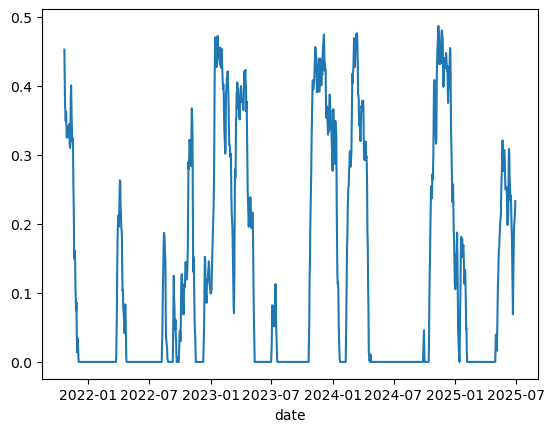

In [90]:
df_donchian_ensemble_only['BTC-USD_final_signal'].plot()

<Axes: xlabel='date'>

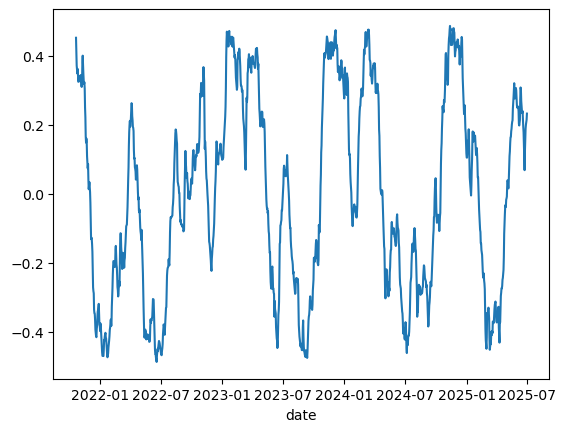

In [91]:
df_donchian_ensemble_only['BTC-USD_final_weighted_additive_signal'].plot()

In [92]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian\n",
## Stop Loss = 2.0 * ATR
# ticker_list_test = ['BTC-USD']
donchian_ensemble_windows = [28, 40, 56]
df_donchian_only = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
    use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)

df_donchian_only = calculate_asset_level_returns(df_donchian_only, end_date=end_date, ticker_list=ticker_list)

## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
perf.calculate_risk_and_performance_metrics(df_donchian_only, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


{'annualized_return': -0.10740574884045384,
 'annualized_sharpe_ratio': -0.18791788951563226,
 'calmar_ratio': -0.1524797560138607,
 'annualized_std_dev': 0.5584208571120177,
 'max_drawdown': -0.7043934988372519,
 'max_drawdown_duration': Timedelta('1182 days 00:00:00'),
 'hit_rate': 0.28169014084507044,
 't_statistic': -0.13374003868782483,
 'p_value': 0.8936281062715756,
 'trade_count': 1878.0}

## Walk Forward Analysis for Ensemble Signal and Best Single Window Signal

In [99]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [28, 40, 56],
        # "exit_window": [0.25, 0.5, 0.75, 1],
        # 'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [103]:
def run_walk_forward_donchian_ribbon_with_ensemble(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        donchian_ensemble_windows = [28, 40, 56]
        df_ensemble_is = apply_target_volatility_position_sizing_continuous_ensemble_strategy(
            start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
            entry_rolling_donchian_window_list=donchian_ensemble_windows,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)
        df_ensemble_is = df_ensemble_is[df_ensemble_is.index >= start_date_is]
        print('Calculating In Sample Asset Returns for Ensemble Signal!!')
        df_ensemble_is = calculate_asset_level_returns(df_ensemble_is, end_date=end_date, ticker_list=ticker_list)
        
        row_parameters_ensemble_is = {
            'sampling_category': 'in_sample',
            'start_date': start_date_is,
            'end_date': end_date_is,
            'entry_window': 284056,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        portfolio_perf_metrics_ensemble_is = calculate_risk_and_performance_metrics(df_ensemble_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                    strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                    passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting In Sample Asset Performance!!')
        for ticker in ticker_list:
            ## In Sample Ensemble Signal
            ticker_perf_metrics_ensemble_is = perf.calculate_risk_and_performance_metrics(df_ensemble_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                          strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_ensemble_is = {key: ticker_perf_metrics_ensemble_is[key] for key in ticker_perf_cols}
            ticker_perf_metrics_ensemble_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_ensemble_is.items()}
            portfolio_perf_metrics_ensemble_is.update(ticker_perf_metrics_ensemble_is)

        row_parameters_ensemble_is.update(portfolio_perf_metrics_ensemble_is)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_ensemble_is

        ## Determine the best performing configuration for the In-Sample period
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_entry_window = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['entry_window'].iloc[0]
        print(f'Best In Sample Entry Window: {best_in_sample_entry_window}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        ## Out of Sample Performance Metrics
        print('Getting Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'entry_window': best_in_sample_entry_window,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        if best_in_sample_entry_window == 284056:
            df_ensemble_os = apply_target_volatility_position_sizing_continuous_ensemble_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
                entry_rolling_donchian_window_list=donchian_ensemble_windows,
                exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date)
            df_ensemble_os = df_ensemble_os[df_ensemble_os.index >= start_date_os]
            print('Calculating In Sample Asset Returns for Ensemble Signal!!')
            df_ensemble_os = calculate_asset_level_returns(df_ensemble_os, end_date=end_date, ticker_list=ticker_list)

            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_ensemble_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
        else:
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            if best_in_sample_entry_window == 284056:
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_ensemble_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
            else:
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [105]:
%%time
df_performance_donchian_ensemble_single_1 = run_walk_forward_donchian_ribbon_with_ensemble(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [107]:
df_performance_donchian_ensemble_single_1

sampling_category  start_date    end_date  entry_window  exit_window  \
0         in_sample  2022-04-01  2023-09-30            28           28   
1         in_sample  2022-04-01  2023-09-30            40           28   
2         in_sample  2022-04-01  2023-09-30            56           28   
3         in_sample  2022-04-01  2023-09-30        284056           28   
4        out_sample  2023-10-01  2024-03-31            56           28   

   exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0      False          -0.487151                -1.448430     -0.768054   
1      False          -0.481762                -1.429358     -0.766643   
2      False          -0.456362                -1.309028     -0.736487   
3      False          -0.522762                -1.598826     -0.778325   
4      False           2.291851                 2.512706      9.998852   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0            0.548746     -0.634267              543 days  0.312044   
1            0.546637     -0.628404              543 days  0.313869   
2            0.561017     -0.619647              543 days  0.317518   
3            0.555767     -0.671650              543 days  0.306569   
4            0.511410     -0.229211               72 days  0.535519   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0    -1.635751  0.102467        844.0                   0.020679   
1    -1.611987  0.107542        780.0                   0.031947   
2    -1.465263  0.143424        745.0                   0.017405   
3    -1.821146  0.069131        766.0                   0.033443   
4     1.847450  0.066305        552.0                   0.122490   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.024010                  -0.187151   
1                   0.014106                  -0.193172   
2                  -0.002620                  -0.198286   
3                  -0.027096                  -0.206073   
4                   0.334718                   0.505124   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                  -0.146959                   -0.075899   
1                  -0.166622                   -0.067090   
2                  -0.127964                   -0.057677   
3                  -0.167016                   -0.076271   
4                   0.305637                    0.340266   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                        -0.204402                        -0.213477   
1                        -0.097659                        -0.309097   
2                        -0.216873                        -0.369132   
3                        -0.087105                        -0.668631   
4                         0.524393                         1.616595   

   SOL-USD_annualized_sharpe_ratio  ADA-USD_annualized_sharpe_ratio  \
0                        -1.413999                        -1.232219   
1                        -1.427148                        -1.569179   
2                        -1.476365                        -1.582183   
3                        -1.515263                        -1.607562   
4                         3.009543                         1.747159   

   AVAX-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_dev  \
0                         -1.550284                    0.153428   
1                         -1.411914                    0.156392   
2                         -1.051869                    0.160163   
3                         -1.507713                    0.156003   
4                          2.082236                    0.151020   

   ETH-USD_annualized_std_dev  SOL-USD_annualized_std_dev  \
0                    0.140685                    0.237394   
1                    0.142695                    0.241034   
2                    0.179780                    0.236686   
3                    0.154726                    0.239942  

In [109]:
df_performance_donchian_ensemble_single_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_Performance-2022-04-01-2024-04-01.pickle')

In [111]:
%%time
df_performance_donchian_ensemble_single_2 = run_walk_forward_donchian_ribbon_with_ensemble(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [112]:
df_performance_donchian_ensemble_single_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_Performance-2022-10-01-2024-10-01.pickle')

In [113]:
%%time
df_performance_donchian_ensemble_single_3 = run_walk_forward_donchian_ribbon_with_ensemble(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [114]:
df_performance_donchian_ensemble_single_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_Performance-2023-04-01-2025-04-01.pickle')

In [115]:
%%time
df_performance_donchian_ensemble_single_4 = run_walk_forward_donchian_ribbon_with_ensemble(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [116]:
df_performance_donchian_ensemble_single_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_Performance-2023-10-01-2025-10-01.pickle')

In [119]:
df_performance_donchian_ensemble_single = pd.concat([df_performance_donchian_ensemble_single_1,df_performance_donchian_ensemble_single_2,df_performance_donchian_ensemble_single_3,df_performance_donchian_ensemble_single_4],
                                                    axis=0, ignore_index=True)

In [133]:
df_performance_donchian_ensemble_single.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_Performance-2022-04-01-2025-10-01.pickle')

In [135]:
df_performance_donchian_ensemble_single_is = df_performance_donchian_ensemble_single[df_performance_donchian_ensemble_single.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_donchian_ensemble_single_os = df_performance_donchian_ensemble_single[df_performance_donchian_ensemble_single.sampling_category == 'out_sample'].reset_index(drop=True)

In [137]:
df_performance_donchian_ensemble_single_is.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
28                          0.889670  0.402797  1.256299          0.433933   
40                          0.960713  0.462795  1.312981          0.485215   
56                          1.210040  0.659338  1.322649          0.631711   
284056                      0.971018  0.441407  1.391917          0.486149   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
28            0.267343  0.529294    -0.442627 -0.477139  0.109398   
40            0.317444  0.590952    -0.428860 -0.456099  0.122685   
56            0.422195  0.603673    -0.372597 -0.426012  0.130177   
284056        0.311779  0.595801    -0.404536 -0.469401  0.134899   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.193309  0.380398  0.708983   
40                                  0.218268  0.419828  0.662552   
56                                  0.477595  0.494533  0.640740   
284056                              0.276285  0.462721  0.661858   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                 -0.176354  0.146211  0.670537   
40                                  0.027522  0.261362  0.710123   
56                                  0.199470  0.377862  0.783451   
284056                             -0.000788  0.160742  0.830677   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.833573  0.446388  1.283622   
40                                  0.569016  0.310391  1.245548   
56                                  0.589829  0.302417  1.266296   
284056                              0.553675  0.260025  1.259539   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.097993  0.003083  0.993036   
40                                  0.380840  0.043362  1.118820   
56                                  0.875564  0.327464  1.290267   
284056                              0.387973  0.127679  1.241911   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
28                                   1.060897  0.516691  1.400922  
40                                   1.072701  0.558734  1.335369  
56                                   0.968671  0.573630  1.118003  
284056                               1.039964  0.511359  1.371875

In [139]:
df_performance_donchian_ensemble_single_os.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
40                          0.065850  0.065850       NaN         -0.036367   
56                          1.399972  1.012777  1.726405          0.888740   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
40           -0.036367       NaN    -0.203298 -0.203298       NaN   
56            0.941536  1.324707    -0.245988 -0.254446  0.030361   

             BTC-USD_annualized_sharpe_ratio                     \
                                      median      mean      std   
entry_window                                                      
40                                 -1.229670 -1.229670      NaN   
56                                  0.524393  0.502556  0.87414   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
40                                 -0.657546 -0.657546       NaN   
56                                  0.463227  0.233229  1.511546   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
40                                 -1.475761 -1.475761       NaN   
56                                 -1.084764  0.247865  2.392169   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
40                                  1.163847  1.163847       NaN   
56                                  0.492058  0.514655  1.221363   

             AVAX-USD_annualized_sharpe_ratio                     
                                       median      mean      std  
entry_window                                                      
40                                   0.556059  0.556059      NaN  
56                                   1.820264  0.609111  2.32834

In [141]:
df_performance_donchian_ensemble_single_os

sampling_category  start_date    end_date  entry_window  exit_window  \
0        out_sample  2023-10-01  2024-03-31            56           28   
1        out_sample  2024-04-01  2024-09-30            40           28   
2        out_sample  2024-10-01  2025-03-31            56           28   
3        out_sample  2025-04-01  2025-07-31            56           28   

   exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0      False           2.291851                 2.512706      9.998852   
1      False          -0.036367                 0.065850     -0.178883   
2      False           0.888740                 1.399972      3.084408   
3      False          -0.355984                -0.874348     -1.447164   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0            0.511410     -0.229211               72 days  0.535519   
1            0.499039     -0.203298               55 days  0.535519   
2            0.529266     -0.288140              112 days  0.500000   
3            0.454688     -0.245988               82 days  0.450549   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0     1.847450  0.066305        552.0                   0.122490   
1     0.117947  0.906240        479.0                  -0.103187   
2     1.055605  0.292556        514.0                   0.257445   
3    -0.381892  0.703441        266.0                  -0.001914   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                   0.334718                   0.505124   
1                  -0.048878                  -0.125729   
2                   0.103792                  -0.127172   
3                  -0.163870                  -0.076571   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                   0.305637                    0.340266   
1                   0.210859                    0.117229   
2                   0.132591                    0.388973   
3                  -0.056639                   -0.146125   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                         0.524393                         1.616595   
1                        -1.229670                        -0.657546   
2                         1.365573                         0.463227   
3                        -0.382298                        -1.380135   

   SOL-USD_annualized_sharpe_ratio  ADA-USD_annualized_sharpe_ratio  \
0                         3.009543                         1.747159   
1                        -1.475761                         1.163847   
2                        -1.181184                         0.492058   
3                        -1.084764                        -0.695254   

   AVAX-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_dev  \
0                          2.082236                    0.151020   
1                          0.556059                    0.123539   
2                          1.820264                    0.140642   
3                         -2.075167                    0.116037   

   ETH-USD_annualized_std_dev  SOL-USD_annualized_std_dev  \
0                    0.157670                    0.122505   
1                    0.137806                    0.119619   
2                    0.125893                    0.150168   
3                    0.159753                    0.113265   

   ADA-USD_annualized_std_dev  AVAX-USD_annualized_std_dev  \
0                    0.129875                     0.122070   
1                    0.129999                     0.127201   
2                    0.194421                     0.162557   
3                    0.143228                     0.097906   

   BTC-USD_max_drawdown  ETH-USD_max_drawdown  SOL-USD_max_drawdown  \
0             -0.112735             -0.073854             -0.043554   
1             -0.063919             -0.088816             -0.069403   
2             -0.058250             -0.059197             -0.164112   
3             -0.

## Running All Configs Out of Sample

In [160]:
def run_walk_forward_donchian_ribbon_with_ensemble_all_oos(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        # print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

             ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        donchian_ensemble_windows = [28, 40, 56]
        df_ensemble_is = apply_target_volatility_position_sizing_continuous_ensemble_strategy(
            start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
            entry_rolling_donchian_window_list=donchian_ensemble_windows,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
        df_ensemble_is = df_ensemble_is[df_ensemble_is.index >= start_date_is]
        print('Calculating In Sample Asset Returns for Ensemble Signal!!')
        df_ensemble_is = calculate_asset_level_returns(df_ensemble_is, end_date=end_date, ticker_list=ticker_list)
        
        row_parameters_ensemble_is = {
            'sampling_category': 'in_sample',
            'start_date': start_date_is,
            'end_date': end_date_is,
            'entry_window': 284056,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        portfolio_perf_metrics_ensemble_is = calculate_risk_and_performance_metrics(df_ensemble_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                    strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                    passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting In Sample Asset Performance!!')
        for ticker in ticker_list:
            ## In Sample Ensemble Signal
            ticker_perf_metrics_ensemble_is = perf.calculate_risk_and_performance_metrics(df_ensemble_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                          strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_ensemble_is = {key: ticker_perf_metrics_ensemble_is[key] for key in ticker_perf_cols}
            ticker_perf_metrics_ensemble_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_ensemble_is.items()}
            portfolio_perf_metrics_ensemble_is.update(ticker_perf_metrics_ensemble_is)

        row_parameters_ensemble_is.update(portfolio_perf_metrics_ensemble_is)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_ensemble_is

        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            # exit_window = params['exit_window'] * entry_window
            exit_window = 28#int(round(max(4, exit_window),0))
            exit_gate = False#params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= start_date_os]
            
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date=end_date, ticker_list=ticker_list)

             ## Out of Sample Performance Metrics
            print('Getting Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample Single Window
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)

            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        donchian_ensemble_windows = [28, 40, 56]
        df_ensemble_os = apply_target_volatility_position_sizing_continuous_ensemble_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
            entry_rolling_donchian_window_list=donchian_ensemble_windows,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
        df_ensemble_is = df_ensemble_is[df_ensemble_is.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns for Ensemble Signal!!')
        df_ensemble_os = calculate_asset_level_returns(df_ensemble_os, end_date=end_date, ticker_list=ticker_list)
        
        row_parameters_ensemble_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'entry_window': 284056,
            'exit_window': exit_window,
            'exit_gate': exit_gate
        }
        portfolio_perf_metrics_ensemble_os = calculate_risk_and_performance_metrics(df_ensemble_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                    strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                    passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample Ensemble Signal
            ticker_perf_metrics_ensemble_os = perf.calculate_risk_and_performance_metrics(df_ensemble_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                          strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_ensemble_os = {key: ticker_perf_metrics_ensemble_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_ensemble_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_ensemble_os.items()}
            portfolio_perf_metrics_ensemble_os.update(ticker_perf_metrics_ensemble_os)

        row_parameters_ensemble_os.update(portfolio_perf_metrics_ensemble_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_ensemble_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [196]:
%%time
df_performance_donchian_ensemble_single_all_oos_1 = run_walk_forward_donchian_ribbon_with_ensemble_all_oos(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [198]:
df_performance_donchian_ensemble_single_all_oos_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_All_OOS_Performance-2022-04-01-2024-04-01.pickle')

In [170]:
%%time
df_performance_donchian_ensemble_single_all_oos_2 = run_walk_forward_donchian_ribbon_with_ensemble_all_oos(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [171]:
df_performance_donchian_ensemble_single_all_oos_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_All_OOS_Performance-2022-10-01-2024-10-01.pickle')

In [172]:
%%time
df_performance_donchian_ensemble_single_all_oos_3 = run_walk_forward_donchian_ribbon_with_ensemble_all_oos(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating 

In [173]:
df_performance_donchian_ensemble_single_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_All_OOS_Performance-2023-04-01-2025-04-01.pickle')

In [174]:
%%time
df_performance_donchian_ensemble_single_all_oos_4 = run_walk_forward_donchian_ribbon_with_ensemble_all_oos(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 28}
28 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 40}
40 28 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [175]:
df_performance_donchian_ensemble_single_all_oos_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_All_OOS_Performance-2023-10-01-2025-10-01.pickle')

In [214]:
df_performance_donchian_ensemble_single_all_oos = pd.concat([df_performance_donchian_ensemble_single_all_oos_1,df_performance_donchian_ensemble_single_all_oos_2,
                                                             df_performance_donchian_ensemble_single_all_oos_3,df_performance_donchian_ensemble_single_all_oos_4], axis=0)

In [206]:
df_performance_donchian_ensemble_single_all_oos.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Entry_Ensemble_Single_All_OOS_Performance-2022-04-01-2025-10-01.pickle')

In [208]:
df_performance_donchian_ensemble_single_all_oos_is = df_performance_donchian_ensemble_single_all_oos[df_performance_donchian_ensemble_single_all_oos.sampling_category == 'in_sample']
df_performance_donchian_ensemble_single_all_oos_os = df_performance_donchian_ensemble_single_all_oos[df_performance_donchian_ensemble_single_all_oos.sampling_category == 'out_sample']

In [210]:
df_performance_donchian_ensemble_single_all_oos_is.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
28                          0.889670  0.402797  1.256299          0.433933   
40                          0.960713  0.462795  1.312981          0.485215   
56                          1.210040  0.659338  1.322649          0.631711   
284056                      0.971018  0.441407  1.391917          0.486149   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
28            0.267343  0.529294    -0.442627 -0.477139  0.109398   
40            0.317444  0.590952    -0.428860 -0.456099  0.122685   
56            0.422195  0.603673    -0.372597 -0.426012  0.130177   
284056        0.311779  0.595801    -0.404536 -0.469401  0.134899   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.193309  0.380398  0.708983   
40                                  0.218268  0.419828  0.662552   
56                                  0.477595  0.494533  0.640740   
284056                              0.276285  0.462721  0.661858   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                 -0.176354  0.146211  0.670537   
40                                  0.027522  0.261362  0.710123   
56                                  0.199470  0.377862  0.783451   
284056                             -0.000788  0.160742  0.830677   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.833573  0.446388  1.283622   
40                                  0.569016  0.310391  1.245548   
56                                  0.589829  0.302417  1.266296   
284056                              0.553675  0.260025  1.259539   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.097993  0.003083  0.993036   
40                                  0.380840  0.043362  1.118820   
56                                  0.875564  0.327464  1.290267   
284056                              0.387973  0.127679  1.241911   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
28                                   1.060897  0.516691  1.400922  
40                                   1.072701  0.558734  1.335369  
56                                   0.968671  0.573630  1.118003  
284056                               1.039964  0.511359  1.371875

In [212]:
df_performance_donchian_ensemble_single_all_oos_os.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
28                          0.434438  0.456443  2.685679          0.238084   
40                          0.349367  0.453407  2.749902          0.183994   
56                          0.360987  0.681930  2.470461          0.177849   
284056                      0.093889  0.176254  1.691119          0.070083   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
28            1.553980  3.132221    -0.220053 -0.235329  0.061698   
40            1.708445  3.503297    -0.218441 -0.235128  0.064054   
56            1.800323  3.620642    -0.219070 -0.218305  0.049082   
284056        0.286903  0.628024    -0.215814 -0.228433  0.059035   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  1.036228  0.552874  1.861597   
40                                  0.976295  0.497094  1.865611   
56                                  1.186931  0.849852  1.404448   
284056                              0.065592 -0.160458  1.165024   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                 -0.051572 -0.432491  2.017328   
40                                 -0.147306 -0.406786  2.062162   
56                                 -0.335345 -0.359395  2.150636   
284056                             -0.668307 -0.737573  1.368546   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.216214  0.012405  2.784949   
40                                  0.172849 -0.034636  2.857804   
56                                  0.088021 -0.045445  2.939685   
284056                             -0.584647 -0.994042  2.674172   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.240652 -3.382114  8.905319   
40                                 -0.071966 -2.218238  6.440978   
56                                  0.572638 -1.250621  5.050998   
284056                             -0.376617 -4.612590  9.563856   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
28                                   0.727265  0.489787  2.206342  
40                                   0.781101  0.592126  1.996355  
56                                   0.741508  0.668614  1.772436  
284056                              -0.003050 -0.045248  1.251755

In [222]:
df_performance_donchian_ensemble_single_all_oos.groupby(['entry_window']).agg(agg_dict)

annualized_sharpe_ratio                     annualized_return  \
                              median      mean       std            median   
entry_window                                                                 
28                          0.889670  0.429620  1.941253          0.433933   
40                          0.795284  0.458101  1.994916          0.363738   
56                          1.028052  0.670634  1.834540          0.489792   
284056                      0.622219  0.308830  1.440861          0.233518   

                                 max_drawdown                      \
                  mean       std       median      mean       std   
entry_window                                                        
28            0.910661  2.190360    -0.355159 -0.356234  0.153189   
40            1.012945  2.441800    -0.328560 -0.345614  0.148862   
56            1.111259  2.513361    -0.301865 -0.322159  0.143602   
284056        0.299341  0.566873    -0.349561 -0.348917  0.160881   

             BTC-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.696399  0.466636  1.307347   
40                                  0.685166  0.458461  1.296720   
56                                  0.912193  0.672193  1.028284   
284056                              0.165117  0.151132  0.938290   

             ETH-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                 -0.176354 -0.143140  1.425657   
40                                  0.027522 -0.072712  1.471792   
56                                  0.007423  0.009234  1.549386   
284056                             -0.251766 -0.288416  1.152808   

             SOL-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.732595  0.229397  2.020876   
40                                  0.543296  0.137878  2.049160   
56                                  0.495833  0.128486  2.103663   
284056                              0.023881 -0.367008  2.047935   

             ADA-USD_annualized_sharpe_ratio                      \
                                      median      mean       std   
entry_window                                                       
28                                  0.097993 -1.689515  6.138771   
40                                  0.380840 -1.087438  4.447207   
56                                  0.875564 -0.461578  3.515533   
284056                              0.387973 -2.242456  6.803039   

             AVAX-USD_annualized_sharpe_ratio                      
                                       median      mean       std  
entry_window                                                       
28                                   0.848255  0.503239  1.711016  
40                                   0.877397  0.575430  1.572448  
56                                   0.777029  0.621122  1.372819  
284056                               0.427607  0.233056  1.251652

In [218]:
df_performance_donchian_ensemble_single_all_oos_is

sampling_category  start_date    end_date  entry_window  exit_window  \
0         in_sample  2022-04-01  2023-09-30            28           28   
1         in_sample  2022-04-01  2023-09-30            40           28   
2         in_sample  2022-04-01  2023-09-30            56           28   
3         in_sample  2022-04-01  2023-09-30        284056           28   
0         in_sample  2022-10-01  2024-03-31            28           28   
1         in_sample  2022-10-01  2024-03-31            40           28   
2         in_sample  2022-10-01  2024-03-31            56           28   
3         in_sample  2022-10-01  2024-03-31        284056           28   
0         in_sample  2023-04-01  2024-09-30            28           28   
1         in_sample  2023-04-01  2024-09-30            40           28   
2         in_sample  2023-04-01  2024-09-30            56           28   
3         in_sample  2023-04-01  2024-09-30        284056           28   
0         in_sample  2023-10-01  2025-03-31            28           28   
1         in_sample  2023-10-01  2025-03-31            40           28   
2         in_sample  2023-10-01  2025-03-31            56           28   
3         in_sample  2023-10-01  2025-03-31        284056           28   

   exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0      False          -0.487151                -1.448430     -0.768054   
1      False          -0.481762                -1.429358     -0.766643   
2      False          -0.456362                -1.309028     -0.736487   
3      False          -0.522762                -1.598826     -0.778325   
0      False           0.572110                 1.068209      1.228349   
1      False           0.781107                 1.343000      2.309101   
2      False           0.737643                 1.298271      1.942374   
3      False           0.675442                 1.222401      1.658676   
0      False           0.295756                 0.711132      0.760230   
1      False           0.222854                 0.578425      0.511249   
2      False           0.525779                 1.121809      1.550026   
3      False           0.296857                 0.719635      0.738718   
0      False           0.688656                 1.280279      1.641620   
1      False           0.747576                 1.359112      1.772267   
2      False           0.881721                 1.526300      2.412824   
3      False           0.797581                 1.422418      2.009619   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
0            0.548746     -0.634267              543 days  0.312044   
1            0.546637     -0.628404              543 days  0.313869   
2            0.561017     -0.619647              543 days  0.317518   
3            0.555767     -0.671650              543 days  0.306569   
0            0.558863     -0.465756              207 days  0.408759   
1            0.554137     -0.338273              201 days  0.410584   
2            0.559282     -0.379763              204 days  0.410584   
3            0.552280     -0.407218              205 days  0.406934   
0            0.570651     -0.389034              204 days  0.293260   
1            0.555596     -0.435901              207 days  0.291439   
2            0.564194     -0.339207              200 days  0.311475   
3            0.555978     -0.401854              204 days  0.302368   
0            0.574648     -0.419498              269 days  0.339416   
1            0.577909     -0.421819              382 days  0.337591   
2            0.583937     -0.365431              253 days  0.343066   
3            0.577710     -0.396882              265 days  0.333942   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0    -1.635751  0.102467        844.0                   0.020679   
1    -1.611987  0.107542        780.0                   0.031947   
2    -1.465263  0.143424        745.0                   0.017405   
3   

In [220]:
df_performance_donchian_ensemble_single_all_oos_os

sampling_category  start_date    end_date  entry_window  exit_window  \
4        out_sample  2023-10-01  2024-03-31            28           28   
5        out_sample  2023-10-01  2024-03-31            40           28   
6        out_sample  2023-10-01  2024-03-31            56           28   
7        out_sample  2023-10-01  2024-03-31        284056           28   
4        out_sample  2024-04-01  2024-09-30            28           28   
5        out_sample  2024-04-01  2024-09-30            40           28   
6        out_sample  2024-04-01  2024-09-30            56           28   
7        out_sample  2024-04-01  2024-09-30        284056           28   
4        out_sample  2024-10-01  2025-03-31            28           28   
5        out_sample  2024-10-01  2025-03-31            40           28   
6        out_sample  2024-10-01  2025-03-31            56           28   
7        out_sample  2024-10-01  2025-03-31        284056           28   
4        out_sample  2025-04-01  2025-07-31            28           28   
5        out_sample  2025-04-01  2025-07-31            40           28   
6        out_sample  2025-04-01  2025-07-31            56           28   
7        out_sample  2025-04-01  2025-07-31        284056           28   

   exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
4      False           6.205326                 3.691563     30.371139   
5      False           6.928696                 3.856237     37.410184   
6      False           7.207316                 3.938868     42.257403   
7      False           1.201992                 2.281135      6.616013   
4      False          -0.465574                -2.734667     -1.449103   
5      False          -0.462902                -2.741345     -1.451803   
6      False          -0.361721                -1.933125     -1.409922   
7      False          -0.194546                -1.763897     -0.643682   
4      False           0.595599                 1.137454      2.525976   
5      False           0.504621                 1.012142      2.005070   
6      False           0.453805                 0.934295      1.715558   
7      False           0.170180                 0.524803      0.680855   
4      False          -0.119431                -0.268578     -0.663781   
5      False          -0.136633                -0.313407     -0.739412   
6      False          -0.098106                -0.212320     -0.540271   
7      False          -0.030013                -0.337024     -0.166865   

   annualized_std_dev  max_drawdown max_drawdown_duration  hit_rate  \
4            0.579233     -0.204317               62 days  0.551913   
5            0.590636     -0.185209               56 days  0.535519   
6            0.590955     -0.170557               54 days  0.535519   
7            0.586575     -0.181679              320 days  0.200000   
4            0.538450     -0.321284              182 days  0.109290   
5            0.523755     -0.318846              182 days  0.109290   
6            0.528094     -0.256554              174 days  0.131148   
7            0.534132     -0.302240              484 days  0.041237   
4            0.564605     -0.235790              112 days  0.357143   
5            0.571242     -0.251673              112 days  0.357143   
6            0.567835     -0.264523              112 days  0.357143   
7            0.565828     -0.249950              307 days  0.134298   
4            0.456066     -0.179926               38 days  0.340659   
5            0.460350     -0.184786               38 days  0.340659   
6            0.464556     -0.181587               38 days  0.329670   
7            0.462275     -0.179863              339 days  0.081425   

   t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
4     2.674935  0.008155        472.0                   0.432028   
5     2.791440  0.005807        462.0                   0.409300   
6     2.850338  0.004871        454.0                   0.400033   
7   

## Walk Forward for Exit Gate and Exit Window

In [227]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [56],
        "exit_window": [0.25, 0.33, 0.5, 0.67, 0.75, 1.0, 1.25, 1.5],
        'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [233]:
def run_walk_forward_donchian_ribbon_exit_window_gate(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            exit_window = params['exit_window'] * entry_window
            exit_window = int(round(max(4, exit_window),0))
            exit_gate = params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Determine the best performing configuration for the In-Sample period
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_exit_window = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['exit_window'].iloc[0]
        best_in_sample_exit_date_config = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['exit_gate'].iloc[0]
        print(f'Best In Sample Exit Window: {best_in_sample_exit_window}')
        print(f'Best In Sample Exit Gate Config: {best_in_sample_exit_date_config}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        ## Out of Sample Performance Metrics
        print('Getting Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'entry_window': entry_window,
            'exit_window': best_in_sample_exit_window,
            'exit_gate': best_in_sample_exit_date_config
        }
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=best_in_sample_exit_window, 
            use_donchian_exit_gate=best_in_sample_exit_date_config, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
        df_os = df_os[df_os.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [235]:
%%time
df_performance_donchian_exit_config_1 = run_walk_forward_donchian_ribbon_exit_window_gate(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': False}
56 14 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [236]:
df_performance_donchian_exit_config_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance-2022-04-01-2024-04-01.pickle')

In [239]:
%%time
df_performance_donchian_exit_config_2 = run_walk_forward_donchian_ribbon_exit_window_gate(start_date='2022-10-01', end_date='2024-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': False}
56 14 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [240]:
df_performance_donchian_exit_config_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance-2022-10-01-2024-10-01.pickle')

In [241]:
%%time
df_performance_donchian_exit_config_3 = run_walk_forward_donchian_ribbon_exit_window_gate(start_date='2023-04-01', end_date='2025-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': False}
56 14 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!


In [242]:
df_performance_donchian_exit_config_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance-2023-04-01-2025-04-01.pickle')

In [243]:
%%time
df_performance_donchian_exit_config_4 = run_walk_forward_donchian_ribbon_exit_window_gate(start_date='2023-10-01', end_date='2025-10-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': False}
56 14 False
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True 

In [244]:
df_performance_donchian_exit_config_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance-2023-10-01-2025-10-01.pickle')

In [251]:
df_performance_donchian_exit_config = pd.concat([df_performance_donchian_exit_config_1,df_performance_donchian_exit_config_2,
                                                 df_performance_donchian_exit_config_3,df_performance_donchian_exit_config_4], axis=0)

In [261]:
df_performance_donchian_exit_config.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance-2022-04-01-2025-10-01.pickle')

In [263]:
df_performance_donchian_exit_config_is = df_performance_donchian_exit_config[df_performance_donchian_exit_config.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_donchian_exit_config_os = df_performance_donchian_exit_config[df_performance_donchian_exit_config.sampling_category == 'out_sample'].reset_index(drop=True)

In [271]:
df_performance_donchian_exit_config.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           14          False                    1.210040  0.717692   
                         True                     1.013169  0.456527   
             18          False                    1.210040  0.659338   
                         True                     1.079227  0.522830   
             28          False                    1.210040  0.659338   
                         True                     1.189964  0.636988   
             38          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             42          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             56          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             70          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             84          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   

                                             annualized_return            \
                                         std            median      mean   
entry_window exit_window exit_gate                                         
56           14          False      1.304328          0.631711  0.559628   
                         True       1.371290          0.490231  0.307064   
             18          False      1.322649          0.631711  0.422195   
                         True       1.337417          0.535651  0.339878   
             28          False      1.322649          0.631711  0.422195   
                         True       1.340746          0.615073  0.411178   
             38          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             42          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             56          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             70          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             84          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           14          False      0.884088    -0.313673 -0.333836  0.132350   
                         True       0.566533    -0.399281 -0.453184  0.145076   
             18          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.569198    -0.385076 -0.440820  0.138230   
             28          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603317    -0.372597 -0.428832  0.135773   
             38          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             42          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             56          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
      

In [267]:
df_performance_donchian_exit_config_is.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           14          False                    1.210040  0.659338   
                         True                     1.013169  0.456527   
             18          False                    1.210040  0.659338   
                         True                     1.079227  0.522830   
             28          False                    1.210040  0.659338   
                         True                     1.189964  0.636988   
             38          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             42          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             56          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             70          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             84          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   

                                             annualized_return            \
                                         std            median      mean   
entry_window exit_window exit_gate                                         
56           14          False      1.322649          0.631711  0.422195   
                         True       1.371290          0.490231  0.307064   
             18          False      1.322649          0.631711  0.422195   
                         True       1.337417          0.535651  0.339878   
             28          False      1.322649          0.631711  0.422195   
                         True       1.340746          0.615073  0.411178   
             38          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             42          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             56          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             70          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             84          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           14          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.566533    -0.399281 -0.453184  0.145076   
             18          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.569198    -0.385076 -0.440820  0.138230   
             28          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603317    -0.372597 -0.428832  0.135773   
             38          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             42          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             56          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
      

In [269]:
df_performance_donchian_exit_config_os.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           14          False                    0.732911  0.776045   

                                             annualized_return           \
                                         std            median     mean   
entry_window exit_window exit_gate                                        
56           14          False      1.486994          0.426187  0.69706   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           14          False      1.187002      -0.2376 -0.241659  0.035617   

                                   BTC-USD_annualized_sharpe_ratio          \
                                                            median    mean   
entry_window exit_window exit_gate                                           
56           14          False                            0.071048  0.0695   

                                             ETH-USD_annualized_sharpe_ratio  \
                                         std                          median   
entry_window exit_window exit_gate                                             
56           14          False      1.122304                       -0.097159   

                                                        \
                                        mean       std   
entry_window exit_window exit_gate                       
56           14          False      0.010535  1.312079   

                                   SOL-USD_annualized_sharpe_ratio            \
                                                            median      mean   
entry_window exit_window exit_gate                                             
56           14          False                           -1.132974 -0.183041   

                                             ADA-USD_annualized_sharpe_ratio  \
                                         std                          median   
entry_window exit_window exit_gate                                             
56           14          False      2.134878                        0.827953   

                                                        \
                                        mean       std   
entry_window exit_window exit_gate                       
56           14          False      0.676953  1.048737   

                                   AVAX-USD_annualized_sharpe_ratio            \
                                                             median      mean   
entry_window exit_window exit_gate                                              
56           14          False                             1.188161  0.595848   

                                              
                                         std  
entry_window exit_window exit_gate            
56           14          False      1.901267

## Walk Forward Exit Gate Configs for All In-Sample and Out of Sample Windows

In [274]:
import itertools

def generate_donchian_channel_params():
    parameter_grid = {
        "entry_window": [56],
        "exit_window": [0.25, 0.33, 0.5, 0.67, 0.75, 1.0, 1.25, 1.5],
        'exit_gate': [True, False],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [278]:
def run_walk_forward_donchian_ribbon_exit_window_gate_all_oos(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'entry_window', 'exit_window', 'exit_gate', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_donchian_channel_params():
            print(params)
            entry_window = params['entry_window']
            exit_window = params['exit_window'] * entry_window
            exit_window = int(round(max(4, exit_window),0))
            exit_gate = params['exit_gate']
            print(entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            ## Out of Sample Dataframe
            ## Out of Sample Performance Metrics
            print('Getting Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'entry_window': entry_window,
                'exit_window': exit_window,
                'exit_gate': exit_gate
            }
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)
    
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [280]:
%%time
df_performance_donchian_exit_config_all_oos_1 = run_walk_forward_donchian_ribbon_exit_window_gate_all_oos(start_date='2022-04-01', end_date='2024-04-01',
                                                                                                          ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Tar

In [281]:
df_performance_donchian_exit_config_all_oos_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance_All_OOS-2022-04-01-2024-04-01.pickle')

In [284]:
df_performance_donchian_exit_config_all_oos_1

sampling_category  start_date    end_date  entry_window  exit_window  \
0          in_sample  2022-04-01  2023-09-30            56           14   
1         out_sample  2023-10-01  2024-03-31            56           14   
2          in_sample  2022-04-01  2023-09-30            56           14   
3         out_sample  2023-10-01  2024-03-31            56           14   
4          in_sample  2022-04-01  2023-09-30            56           18   
5         out_sample  2023-10-01  2024-03-31            56           18   
6          in_sample  2022-04-01  2023-09-30            56           18   
7         out_sample  2023-10-01  2024-03-31            56           18   
8          in_sample  2022-04-01  2023-09-30            56           28   
9         out_sample  2023-10-01  2024-03-31            56           28   
10         in_sample  2022-04-01  2023-09-30            56           28   
11        out_sample  2023-10-01  2024-03-31            56           28   
12         in_sample  2022-04-01  2023-09-30            56           38   
13        out_sample  2023-10-01  2024-03-31            56           38   
14         in_sample  2022-04-01  2023-09-30            56           38   
15        out_sample  2023-10-01  2024-03-31            56           38   
16         in_sample  2022-04-01  2023-09-30            56           42   
17        out_sample  2023-10-01  2024-03-31            56           42   
18         in_sample  2022-04-01  2023-09-30            56           42   
19        out_sample  2023-10-01  2024-03-31            56           42   
20         in_sample  2022-04-01  2023-09-30            56           56   
21        out_sample  2023-10-01  2024-03-31            56           56   
22         in_sample  2022-04-01  2023-09-30            56           56   
23        out_sample  2023-10-01  2024-03-31            56           56   
24         in_sample  2022-04-01  2023-09-30            56           70   
25        out_sample  2023-10-01  2024-03-31            56           70   
26         in_sample  2022-04-01  2023-09-30            56           70   
27        out_sample  2023-10-01  2024-03-31            56           70   
28         in_sample  2022-04-01  2023-09-30            56           84   
29        out_sample  2023-10-01  2024-03-31            56           84   
30         in_sample  2022-04-01  2023-09-30            56           84   
31        out_sample  2023-10-01  2024-03-31            56           84   

    exit_gate  annualized_return  annualized_sharpe_ratio  calmar_ratio  \
0        True          -0.518713                -1.583622     -0.777286   
1        True           2.147164                 2.425126      8.894181   
2       False          -0.456362                -1.309028     -0.736487   
3       False           2.291851                 2.512706      9.998852   
4        True          -0.492538                -1.469473     -0.762098   
5        True           2.185985                 2.454830      9.384729   
6       False          -0.456362                -1.309028     -0.736487   
7       False           2.291851                 2.512706      9.998852   
8        True          -0.467155                -1.358274     -0.740425   
9        True           2.302390                 2.518690     10.044831   
10      False          -0.456362                -1.309028     -0.736487   
11      False           2.291851                 2.512706      9.998852   
12       True          -0.456362                -1.309028     -0.736487   
13       True           2.291851                 2.512706      9.998852   
14      False          -0.456362                -1.309028     -0.736487   
15      False           2.291851                 2.512706      9.998852   
16       True          -0.456362                -1.309028     -0.736487   
17       True           2.291851                 2.512706      9.998852   
18      False          -0.456362                -1.309028     -0.736487   
19      False           2.2

In [286]:
%%time
df_performance_donchian_exit_config_all_oos_2 = run_walk_forward_donchian_ribbon_exit_window_gate_all_oos(start_date='2022-10-01', end_date='2024-10-01',
                                                                                                  ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Tar

In [287]:
df_performance_donchian_exit_config_all_oos_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance_All_OOS-2022-10-01-2024-10-01.pickle')

In [288]:
%%time
df_performance_donchian_exit_config_all_oos_3 = run_walk_forward_donchian_ribbon_exit_window_gate_all_oos(start_date='2023-04-01', end_date='2025-04-01',
                                                                                                  ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Tar

In [289]:
df_performance_donchian_exit_config_all_oos_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance_All_OOS-2023-04-01-2025-04-01.pickle')

In [290]:
%%time
df_performance_donchian_exit_config_all_oos_4 = run_walk_forward_donchian_ribbon_exit_window_gate_all_oos(start_date='2023-10-01', end_date='2025-10-01',
                                                                                                  ticker_list=ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'entry_window': 56, 'exit_window': 0.25, 'exit_gate': True}
56 14 True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calcul

In [291]:
df_performance_donchian_exit_config_all_oos_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance_All_OOS-2023-10-01-2025-10-01.pickle')

In [304]:
df_performance_donchian_exit_config_all_oos = pd.concat([df_performance_donchian_exit_config_all_oos_1,df_performance_donchian_exit_config_all_oos_2,
                                                         df_performance_donchian_exit_config_all_oos_3,df_performance_donchian_exit_config_all_oos_4], axis=0, ignore_index=True)

In [308]:
df_performance_donchian_exit_config_all_oos.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Donchian_Channel_Exit_Config_Performance_All_OOS-2022-04-01-2025-10-01.pickle')

In [310]:
df_performance_donchian_exit_config_all_oos_is = df_performance_donchian_exit_config_all_oos[df_performance_donchian_exit_config_all_oos.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_donchian_exit_config_all_oos_os = df_performance_donchian_exit_config_all_oos[df_performance_donchian_exit_config_all_oos.sampling_category == 'out_sample'].reset_index(drop=True)

In [322]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}

In [324]:
df_performance_donchian_exit_config_all_oos_is.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           14          False                    1.210040  0.659338   
             18          False                    1.210040  0.659338   
             28          False                    1.210040  0.659338   
             38          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             42          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             56          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             70          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             84          False                    1.210040  0.659338   
                         True                     1.210040  0.659338   
             28          True                     1.189964  0.636988   
             18          True                     1.079227  0.522830   
             14          True                     1.013169  0.456527   

                                             annualized_return            \
                                         std            median      mean   
entry_window exit_window exit_gate                                         
56           14          False      1.322649          0.631711  0.422195   
             18          False      1.322649          0.631711  0.422195   
             28          False      1.322649          0.631711  0.422195   
             38          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             42          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             56          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             70          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             84          False      1.322649          0.631711  0.422195   
                         True       1.322649          0.631711  0.422195   
             28          True       1.340746          0.615073  0.411178   
             18          True       1.337417          0.535651  0.339878   
             14          True       1.371290          0.490231  0.307064   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           14          False      0.603673    -0.372597 -0.426012  0.130177   
             18          False      0.603673    -0.372597 -0.426012  0.130177   
             28          False      0.603673    -0.372597 -0.426012  0.130177   
             38          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             42          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             56          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             70          False      0.603673    -0.372597 -0.426012  0.130177   
                         True       0.603673    -0.372597 -0.426012  0.130177   
             84          False      0.603673    -0.372597 -0.426012  0.130177   
      

In [326]:
df_performance_donchian_exit_config_all_oos_os.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           28          True                     0.746978  0.784574   
             14          False                    0.732911  0.776045   
             18          False                    0.732911  0.776045   
             28          False                    0.732911  0.776045   
             38          False                    0.732911  0.776045   
             42          False                    0.732911  0.776045   
                         True                     0.732911  0.776045   
             56          False                    0.732911  0.776045   
                         True                     0.732911  0.776045   
             70          False                    0.732911  0.776045   
                         True                     0.732911  0.776045   
             84          False                    0.732911  0.776045   
                         True                     0.732911  0.776045   
             38          True                     0.732172  0.775675   
             18          True                     0.680767  0.707327   
             14          True                     0.761922  0.706519   

                                             annualized_return            \
                                         std            median      mean   
entry_window exit_window exit_gate                                         
56           28          True       1.484903          0.432884  0.703043   
             14          False      1.486994          0.426187  0.697060   
             18          False      1.486994          0.426187  0.697060   
             28          False      1.486994          0.426187  0.697060   
             38          False      1.486994          0.426187  0.697060   
             42          False      1.486994          0.426187  0.697060   
                         True       1.486994          0.426187  0.697060   
             56          False      1.486994          0.426187  0.697060   
                         True       1.486994          0.426187  0.697060   
             70          False      1.486994          0.426187  0.697060   
                         True       1.486994          0.426187  0.697060   
             84          False      1.486994          0.426187  0.697060   
                         True       1.486994          0.426187  0.697060   
             38          True       1.487229          0.425851  0.696892   
             18          True       1.492309          0.377521  0.638004   
             14          True       1.528106          0.429060  0.644986   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           28          True       1.188982    -0.237600 -0.241659  0.035617   
             14          False      1.187002    -0.237600 -0.241659  0.035617   
             18          False      1.187002    -0.237600 -0.241659  0.035617   
             28          False      1.187002    -0.237600 -0.241659  0.035617   
             38          False      1.187002    -0.237600 -0.241659  0.035617   
             42          False      1.187002    -0.237600 -0.241659  0.035617   
                         True       1.187002    -0.237600 -0.241659  0.035617   
             56          False      1.187002    -0.237600 -0.241659  0.035617   
                         True       1.187002    -0.237600 -0.241659  0.035617   
             70          False      1.187002    -0.237600 -0.241659  0.035617   
                         True       1.187002    -0.237600 -0.241659  0.035617   
             84          False      1.187002    -0.237600 -0.241659  0.035617   
      

In [328]:
df_performance_donchian_exit_config_all_oos.groupby(['entry_window','exit_window','exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio            \
                                                    median      mean   
entry_window exit_window exit_gate                                     
56           14          False                    1.210040  0.717692   
             18          False                    1.210040  0.717692   
             28          False                    1.210040  0.717692   
             38          False                    1.210040  0.717692   
             42          False                    1.210040  0.717692   
                         True                     1.210040  0.717692   
             56          False                    1.210040  0.717692   
                         True                     1.210040  0.717692   
             70          False                    1.210040  0.717692   
                         True                     1.210040  0.717692   
             84          False                    1.210040  0.717692   
                         True                     1.210040  0.717692   
             38          True                     1.210040  0.717507   
             28          True                     1.189964  0.710781   
             18          True                     1.079227  0.615078   
             14          True                     1.013169  0.581523   

                                             annualized_return            \
                                         std            median      mean   
entry_window exit_window exit_gate                                         
56           14          False      1.304328          0.631711  0.559628   
             18          False      1.304328          0.631711  0.559628   
             28          False      1.304328          0.631711  0.559628   
             38          False      1.304328          0.631711  0.559628   
             42          False      1.304328          0.631711  0.559628   
                         True       1.304328          0.631711  0.559628   
             56          False      1.304328          0.631711  0.559628   
                         True       1.304328          0.631711  0.559628   
             70          False      1.304328          0.631711  0.559628   
                         True       1.304328          0.631711  0.559628   
             84          False      1.304328          0.631711  0.559628   
                         True       1.304328          0.631711  0.559628   
             38          True       1.304433          0.631711  0.559544   
             28          True       1.312096          0.615073  0.557111   
             18          True       1.315571          0.535651  0.488941   
             14          True       1.350747          0.490231  0.476025   

                                             max_drawdown                      \
                                         std       median      mean       std   
entry_window exit_window exit_gate                                              
56           14          False      0.884088    -0.313673 -0.333836  0.132350   
             18          False      0.884088    -0.313673 -0.333836  0.132350   
             28          False      0.884088    -0.313673 -0.333836  0.132350   
             38          False      0.884088    -0.313673 -0.333836  0.132350   
             42          False      0.884088    -0.313673 -0.333836  0.132350   
                         True       0.884088    -0.313673 -0.333836  0.132350   
             56          False      0.884088    -0.313673 -0.333836  0.132350   
                         True       0.884088    -0.313673 -0.333836  0.132350   
             70          False      0.884088    -0.313673 -0.333836  0.132350   
                         True       0.884088    -0.313673 -0.333836  0.132350   
             84          False      0.884088    -0.313673 -0.333836  0.132350   
                         True       0.884088    -0.313673 -0.333836  0.132350   
      

In [306]:
df_performance_donchian_exit_config_all_oos

sampling_category  start_date    end_date  entry_window  exit_window  \
0           in_sample  2022-04-01  2023-09-30            56           14   
1          out_sample  2023-10-01  2024-03-31            56           14   
2           in_sample  2022-04-01  2023-09-30            56           14   
3          out_sample  2023-10-01  2024-03-31            56           14   
4           in_sample  2022-04-01  2023-09-30            56           18   
5          out_sample  2023-10-01  2024-03-31            56           18   
6           in_sample  2022-04-01  2023-09-30            56           18   
7          out_sample  2023-10-01  2024-03-31            56           18   
8           in_sample  2022-04-01  2023-09-30            56           28   
9          out_sample  2023-10-01  2024-03-31            56           28   
10          in_sample  2022-04-01  2023-09-30            56           28   
11         out_sample  2023-10-01  2024-03-31            56           28   
12          in_sample  2022-04-01  2023-09-30            56           38   
13         out_sample  2023-10-01  2024-03-31            56           38   
14          in_sample  2022-04-01  2023-09-30            56           38   
15         out_sample  2023-10-01  2024-03-31            56           38   
16          in_sample  2022-04-01  2023-09-30            56           42   
17         out_sample  2023-10-01  2024-03-31            56           42   
18          in_sample  2022-04-01  2023-09-30            56           42   
19         out_sample  2023-10-01  2024-03-31            56           42   
20          in_sample  2022-04-01  2023-09-30            56           56   
21         out_sample  2023-10-01  2024-03-31            56           56   
22          in_sample  2022-04-01  2023-09-30            56           56   
23         out_sample  2023-10-01  2024-03-31            56           56   
24          in_sample  2022-04-01  2023-09-30            56           70   
25         out_sample  2023-10-01  2024-03-31            56           70   
26          in_sample  2022-04-01  2023-09-30            56           70   
27         out_sample  2023-10-01  2024-03-31            56           70   
28          in_sample  2022-04-01  2023-09-30            56           84   
29         out_sample  2023-10-01  2024-03-31            56           84   
30          in_sample  2022-04-01  2023-09-30            56           84   
31         out_sample  2023-10-01  2024-03-31            56           84   
32          in_sample  2022-10-01  2024-03-31            56           14   
33         out_sample  2024-04-01  2024-09-30            56           14   
34          in_sample  2022-10-01  2024-03-31            56           14   
35         out_sample  2024-04-01  2024-09-30            56           14   
36          in_sample  2022-10-01  2024-03-31            56           18   
37         out_sample  2024-04-01  2024-09-30            56           18   
38          in_sample  2022-10-01  2024-03-31            56           18   
39         out_sample  2024-04-01  2024-09-30            56           18   
40          in_sample  2022-10-01  2024-03-31            56           28   
41         out_sample  2024-04-01  2024-09-30            56           28   
42          in_sample  2022-10-01  2024-03-31            56           28   
43         out_sample  2024-04-01  2024-09-30            56           28   
44          in_sample  2022-10-01  2024-03-31            56           38   
45         out_sample  2024-04-01  2024-09-30            56           38   
46          in_sample  2022-10-01  2024-03-31            56           38   
47         out_sample  2024-04-01  2024-09-30            56           38   
48          in_sample  2022-10-01  2024-03-31            56           42   
49         out_sample  2024-04-01  2024-09-30            56           42   
50          in_sample  2022-10-01  2024-03-31            56           42   
51         out_sample  2024-04-01  2024-09-30       

## Locking Moving Average Ribbon and Donchian Channel Parameters

In [367]:
start_date = pd.to_datetime('2022-04-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-10-01').date()
WARMUP_DAYS = 285
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 20
slow_mavg = 200
mavg_stepsize = 8
mavg_z_score_window = 126
entry_rolling_donchian_window = 56
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-07-31'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.6
donchian_signal_weight = 0.4
use_activation = False
tanh_activation_constant_dict = None
lower_r_sqr_limit = 0.30
upper_r_sqr_limit = 0.90
r2_window = 80
log_std_window = 14
coef_of_variation_window = 30
vol_of_vol_z_score_window = 252
vol_of_vol_p_min = 0.6
use_specific_start_date = True
signal_start_date = pd.Timestamp('2021-06-01').date()

## Walk Forward Analysis for Moving Average Ribbon and Donchian Channel Weights

In [385]:
import itertools

def generate_mavg_ribbon_donchian_weight_params():
    parameter_grid = {
        "mavg_ribbon_weight": [np.round(i,2) for i in np.arange(0, 1.05,0.05)]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [387]:
def run_walk_forward_mavg_ribbon_donchian_weights(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                  entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'ma_crossover_signal_weight', 'donchian_signal_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_mavg_ribbon_donchian_weight_params():
            print(params)
            ma_crossover_signal_weight = params['mavg_ribbon_weight']
            donchian_signal_weight = 1 - ma_crossover_signal_weight
            print(ma_crossover_signal_weight, donchian_signal_weight)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'donchian_signal_weight': donchian_signal_weight
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is
            
        ## Determine the best performing configuration for the In-Sample period
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_ma_crossover_signal_weight = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['ma_crossover_signal_weight'].iloc[0]
        best_in_sample_donchian_signal_weight = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_signal_weight'].iloc[0]
        print(f'Best In Sample Moving Avg Ribbon Weight: {best_in_sample_ma_crossover_signal_weight}')
        print(f'Best In Sample Donchian Signal Weight: {best_in_sample_donchian_signal_weight}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        ## Out of Sample Performance Metrics
        print('Getting Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'ma_crossover_signal_weight': best_in_sample_ma_crossover_signal_weight,
            'donchian_signal_weight': best_in_sample_donchian_signal_weight
        }
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
            use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=best_in_sample_ma_crossover_signal_weight, donchian_signal_weight=best_in_sample_donchian_signal_weight, 
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
        df_os = df_os[df_os.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
    
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [389]:
%%time
df_performance_mavg_donchian_weight_1 = run_walk_forward_mavg_ribbon_donchian_weights(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list, fast_mavg=20, slow_mavg=200,
                                                                                      mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'mavg_ribbon_weight': 0.0}
0.0 1.0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'mavg_ribbon_weight': 0.05}
0.05 0.95
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Cal

In [390]:
df_performance_mavg_donchian_weight_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Weights_Performance-2022-04-01-2024-04-01.pickle')

In [391]:
df_performance_mavg_donchian_weight_1

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0          in_sample  2022-04-01  2023-09-30                        0.00   
1          in_sample  2022-04-01  2023-09-30                        0.05   
2          in_sample  2022-04-01  2023-09-30                        0.10   
3          in_sample  2022-04-01  2023-09-30                        0.15   
4          in_sample  2022-04-01  2023-09-30                        0.20   
5          in_sample  2022-04-01  2023-09-30                        0.25   
6          in_sample  2022-04-01  2023-09-30                        0.30   
7          in_sample  2022-04-01  2023-09-30                        0.35   
8          in_sample  2022-04-01  2023-09-30                        0.40   
9          in_sample  2022-04-01  2023-09-30                        0.45   
10         in_sample  2022-04-01  2023-09-30                        0.50   
11         in_sample  2022-04-01  2023-09-30                        0.55   
12         in_sample  2022-04-01  2023-09-30                        0.60   
13         in_sample  2022-04-01  2023-09-30                        0.65   
14         in_sample  2022-04-01  2023-09-30                        0.70   
15         in_sample  2022-04-01  2023-09-30                        0.75   
16         in_sample  2022-04-01  2023-09-30                        0.80   
17         in_sample  2022-04-01  2023-09-30                        0.85   
18         in_sample  2022-04-01  2023-09-30                        0.90   
19         in_sample  2022-04-01  2023-09-30                        0.95   
20         in_sample  2022-04-01  2023-09-30                        1.00   
21        out_sample  2023-10-01  2024-03-31                        0.95   

    donchian_signal_weight  annualized_return  annualized_sharpe_ratio  \
0                     1.00          -0.560064                -1.827210   
1                     0.95          -0.516049                -1.591793   
2                     0.90          -0.516721                -1.650212   
3                     0.85          -0.515142                -1.649666   
4                     0.80          -0.517737                -1.659799   
5                     0.75          -0.553872                -1.866890   
6                     0.70          -0.544246                -1.771018   
7                     0.65          -0.569106                -1.929604   
8                     0.60          -0.562251                -1.851946   
9                     0.55          -0.536566                -1.716769   
10                    0.50          -0.500104                -1.508895   
11                    0.45          -0.461785                -1.340857   
12                    0.40          -0.456362                -1.309028   
13                    0.35          -0.473114                -1.390140   
14                    0.30          -0.442738                -1.275641   
15                    0.25          -0.468157                -1.374218   
16                    0.20          -0.455553                -1.312215   
17                    0.15          -0.465611                -1.287639   
18                    0.10          -0.448317                -1.213981   
19                    0.05          -0.421057                -1.102578   
20                    0.00          -0.460614                -1.315144   
21                    0.05           2.858562                 2.891660   

    calmar_ratio  annualized_std_dev  max_drawdown max_drawdown_duration  \
0      -0.790192            0.566311     -0.708770              544 days   
1      -0.777268            0.575214     -0.663927              544 days   
2      -0.777481            0.561417     -0.664609              544 days   
3      -0.777055            0.555744     -0.662942              544 days   
4      -0.777823            0.553135     -0.665624              544 days   
5      -0.788429            0.542569     -0.702501              544 days   
6      -0.785591   

In [395]:
%%time
df_performance_mavg_donchian_weight_2 = run_walk_forward_mavg_ribbon_donchian_weights(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200,
                                                                                      mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'mavg_ribbon_weight': 0.0}
0.0 1.0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'mavg_ribbon_weight': 0.05}
0.05 0.95
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Cal

In [396]:
df_performance_mavg_donchian_weight_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Weights_Performance-2022-10-01-2024-10-01.pickle')

In [397]:
%%time
df_performance_mavg_donchian_weight_3 = run_walk_forward_mavg_ribbon_donchian_weights(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200,
                                                                                      mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'mavg_ribbon_weight': 0.0}
0.0 1.0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'mavg_ribbon_weight': 0.05}
0.05 0.95
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Cal

In [398]:
df_performance_mavg_donchian_weight_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Weights_Performance-2023-04-01-2025-04-01.pickle')

In [399]:
%%time
df_performance_mavg_donchian_weight_4 = run_walk_forward_mavg_ribbon_donchian_weights(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list, fast_mavg=20, slow_mavg=200,
                                                                                      mavg_stepsize=8, mavg_z_score_window=126,
                                                                                      entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'mavg_ribbon_weight': 0.0}
0.0 1.0
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'mavg_ribbon_weight': 0.05}
0.05 0.95
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Posit

In [400]:
df_performance_mavg_donchian_weight_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Weights_Performance-2023-10-01-2025-10-01.pickle')

In [405]:
df_performance_mavg_donchian_weight = pd.concat([df_performance_mavg_donchian_weight_1,df_performance_mavg_donchian_weight_2,
                                                 df_performance_mavg_donchian_weight_3,df_performance_mavg_donchian_weight_4], axis=0, ignore_index=True)

In [411]:
df_performance_mavg_donchian_weight.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Weights_Performance-2022-04-01-2025-10-01.pickle')

In [413]:
df_performance_mavg_donchian_weight_is = df_performance_mavg_donchian_weight[df_performance_mavg_donchian_weight.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_mavg_donchian_weight_os = df_performance_mavg_donchian_weight[df_performance_mavg_donchian_weight.sampling_category == 'out_sample'].reset_index(drop=True)

In [421]:
df_performance_mavg_donchian_weight_is.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.90                       0.10                                  1.291355   
0.95                       0.05                                  1.220012   
1.00                       0.00                                  1.276026   
0.85                       0.15                                  1.249156   
0.70                       0.30                                  1.203876   
0.80                       0.20                                  1.172194   
0.65                       0.35                                  1.248703   
0.60                       0.40                                  1.210040   
0.75                       0.25                                  1.144797   
0.55                       0.45                                  1.114044   
0.50                       0.50                                  1.060213   
0.45                       0.55                                  0.920362   
0.40                       0.60                                  0.920950   
0.35                       0.65                                  0.761800   
0.30                       0.70                                  0.743002   
0.25                       0.75                                  0.682733   
0.20                       0.80                                  0.472070   
0.10                       0.90                                  0.398506   
0.05                       0.95                                  0.319737   
0.15                       0.85                                  0.361835   
0.00                       1.00                                  0.239941   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.767599  1.335145   
0.95                       0.05                    0.766814  1.272026   
1.00                       0.00                    0.738755  1.386040   
0.85                       0.15                    0.726330  1.359081   
0.70                       0.30                    0.709724  1.344718   
0.80                       0.20                    0.694137  1.364607   
0.65                       0.35                    0.667722  1.380565   
0.60                       0.40                    0.659338  1.322649   
0.75                       0.25                    0.648960  1.372370   
0.55                       0.45                    0.579110  1.299266   
0.50                       0.50                    0.459784  1.320655   
0.45                       0.55                    0.368257  1.412452   
0.40                       0.60                    0.317324  1.460493   
0.35                       0.65                    0.235193  1.497328   
0.30                       0.70                    0.195502  1.330057   
0.25                       0.75                    0.178911  1.395151   
0.20                       0.80                    0.078635  1.201229   
0.10                       0.90                    0.035371  1.179767   
0.05                       0.95                    0.029286  1.155572   
0.15                       0.85                    0.000853  1.141338   
0.00                       1.00                   -0.086414  1.232803   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.90                       0.10                            0.688092  0.488555   
0.95                       0.05                            0.634392  0.474777   
1.00                       0.00            

In [423]:
df_performance_mavg_donchian_weight_os.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.95                       0.05                                  2.891660   
0.90                       0.10                                  1.601837   
1.00                       0.00                                  0.143312   
0.80                       0.20                                 -0.696376   

                                                                 \
                                                       mean std   
ma_crossover_signal_weight donchian_signal_weight                 
0.95                       0.05                    2.891660 NaN   
0.90                       0.10                    1.601837 NaN   
1.00                       0.00                    0.143312 NaN   
0.80                       0.20                   -0.696376 NaN   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.95                       0.05                            2.858562  2.858562   
0.90                       0.10                            1.082262  1.082262   
1.00                       0.00                            0.002147  0.002147   
0.80                       0.20                           -0.282434 -0.282434   

                                                      max_drawdown            \
                                                  std       median      mean   
ma_crossover_signal_weight donchian_signal_weight                              
0.95                       0.05                   NaN    -0.197712 -0.197712   
0.90                       0.10                   NaN    -0.217548 -0.217548   
1.00                       0.00                   NaN    -0.199815 -0.199815   
0.80                       0.20                   NaN    -0.317077 -0.317077   

                                                      trade_count             \
                                                  std      median   mean std   
ma_crossover_signal_weight donchian_signal_weight                              
0.95                       0.05                   NaN       529.0  529.0 NaN   
0.90                       0.10                   NaN       474.0  474.0 NaN   
1.00                       0.00                   NaN       416.0  416.0 NaN   
0.80                       0.20                   NaN       300.0  300.0 NaN   

                                                  BTC-USD_annualized_sharpe_ratio  \
                                                                           median   
ma_crossover_signal_weight donchian_signal_weight                                   
0.95                       0.05                                          0.771784   
0.90                       0.10                                          1.508690   
1.00                       0.00                                         -1.131615   
0.80                       0.20                                         -0.270970   

                                                                 \
                                                       mean std   
ma_crossover_signal_weight donchian_signal_weight                 
0.95                       0.05                    0.771784 NaN   
0.90                       0.10                    1.508690 NaN   
1.00                       0.00                   -1.131615 NaN   
0.80                       0.20                   -0.270970 NaN   

                                                  ETH-USD_annualized_sharpe_ratio  \
                                                                           median   
ma_crossover_signal_weight donchian_signal_weight                                   
0.95                       0.

## Run Walk Forward Analysis for Locked Weights on the Moving Average Ribbon and Donchian Channel across all OOS Periods

In [434]:
import itertools

def generate_mavg_ribbon_donchian_weight_locked_params():
    parameter_grid = {
        "mavg_ribbon_weight": [0.90, 0.95, 1.0]#[np.round(i,2) for i in np.arange(0, 1.05,0.05)]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [436]:
def run_walk_forward_mavg_ribbon_donchian_weights_locked_params(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'ma_crossover_signal_weight', 'donchian_signal_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_mavg_ribbon_donchian_weight_locked_params():
            print(params)
            ma_crossover_signal_weight = params['mavg_ribbon_weight']
            donchian_signal_weight = 1 - ma_crossover_signal_weight
            print(ma_crossover_signal_weight, donchian_signal_weight)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'donchian_signal_weight': donchian_signal_weight
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is
            
        ## Determine the best performing configuration for the In-Sample period
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # best_in_sample_ma_crossover_signal_weight = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['ma_crossover_signal_weight'].iloc[0]
        # best_in_sample_donchian_signal_weight = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_signal_weight'].iloc[0]
        # print(f'Best In Sample Moving Avg Ribbon Weight: {best_in_sample_ma_crossover_signal_weight}')
        # print(f'Best In Sample Donchian Signal Weight: {best_in_sample_donchian_signal_weight}')

            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            ## Out of Sample Dataframe
            ## Out of Sample Performance Metrics
            print('Getting Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'donchian_signal_weight': donchian_signal_weight
            }
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)
    
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
    
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [438]:
%%time
df_performance_mavg_donchian_weight_locked_weights_1 = run_walk_forward_mavg_ribbon_donchian_weights_locked_params(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list,
                                                                                                                   fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                                   entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)


Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'mavg_ribbon_weight': 0.9}
0.9 0.09999999999999998
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [439]:
df_performance_mavg_donchian_weight_locked_weights_1

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0         in_sample  2022-04-01  2023-09-30                        0.90   
1        out_sample  2023-10-01  2024-03-31                        0.90   
2         in_sample  2022-04-01  2023-09-30                        0.95   
3        out_sample  2023-10-01  2024-03-31                        0.95   
4         in_sample  2022-04-01  2023-09-30                        1.00   
5        out_sample  2023-10-01  2024-03-31                        1.00   

   donchian_signal_weight  annualized_return  annualized_sharpe_ratio  \
0                    0.10          -0.448317                -1.213981   
1                    0.10           2.879281                 2.887089   
2                    0.05          -0.421057                -1.102578   
3                    0.05           2.858562                 2.891660   
4                    0.00          -0.460614                -1.315144   
5                    0.00           2.849917                 2.908314   

   calmar_ratio  annualized_std_dev  max_drawdown max_drawdown_duration  \
0     -0.697636            0.586263     -0.642624              543 days   
1     14.651051            0.505479     -0.196524               50 days   
2     -0.683363            0.573665     -0.616154              543 days   
3     14.458238            0.502206     -0.197712               33 days   
4     -0.747183            0.563999     -0.616468              543 days   
5     14.421709            0.494056     -0.197613               33 days   

   hit_rate  t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0  0.304745    -1.353792  0.176362        682.0                   0.031428   
1  0.546448     2.113961  0.035881        520.0                   0.163002   
2  0.312044    -1.217624  0.223892        669.0                   0.048326   
3  0.557377     2.117649  0.035563        529.0                   0.164839   
4  0.317518    -1.473665  0.141147        657.0                   0.044846   
5  0.568306     2.130065  0.034510        514.0                   0.166847   

   ETH-USD_annualized_return  SOL-USD_annualized_return  \
0                  -0.101743                  -0.131799   
1                   0.511066                   0.355648   
2                  -0.073460                  -0.132448   
3                   0.523199                   0.329471   
4                  -0.068809                  -0.202075   
5                   0.527357                   0.311526   

   ADA-USD_annualized_return  AVAX-USD_annualized_return  \
0                  -0.143467                   -0.052635   
1                   0.392601                    0.326351   
2                  -0.143184                   -0.054874   
3                   0.401560                    0.321020   
4                  -0.136340                   -0.057786   
5                   0.409957                    0.315165   

   BTC-USD_annualized_sharpe_ratio  ETH-USD_annualized_sharpe_ratio  \
0                        -0.101070                        -1.088587   
1                         0.760033                         2.251878   
2                         0.043824                        -0.834838   
3                         0.771784                         2.294861   
4                         0.015717                        -0.818712   
5                         0.782243                         2.315545   

   SOL-USD_annualized_sharpe_ratio  ADA-USD_annualized_sharpe_ratio  \
0                        -0.829928                        -1.709583   
1                         2.212831                         2.334354   
2                        -0.832033                        -1.687006   
3                         2.060367                         2.400769   
4                        -1.509315                        -1.602056   
5                         1.952467                         2.469081   

   AVAX-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_

In [468]:
df_performance_mavg_donchian_weight_locked_weights_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Locked_Weights_Performance-2022-04-01-2024-04-01.pickle')

In [444]:
%%time
df_performance_mavg_donchian_weight_locked_weights_2 = run_walk_forward_mavg_ribbon_donchian_weights_locked_params(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, 
                                                                                                                   fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                                   entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'mavg_ribbon_weight': 0.9}
0.9 0.09999999999999998
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [470]:
df_performance_mavg_donchian_weight_locked_weights_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Locked_Weights_Performance-2022-10-01-2024-10-01.pickle')

In [446]:
%%time
df_performance_mavg_donchian_weight_locked_weights_3 = run_walk_forward_mavg_ribbon_donchian_weights_locked_params(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,
                                                                                                                   fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                                   entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'mavg_ribbon_weight': 0.9}
0.9 0.09999999999999998
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size 

In [472]:
df_performance_mavg_donchian_weight_locked_weights_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Locked_Weights_Performance-2023-04-01-2025-04-01.pickle')

In [448]:
%%time
df_performance_mavg_donchian_weight_locked_weights_4 = run_walk_forward_mavg_ribbon_donchian_weights_locked_params(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,
                                                                                                                   fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                                   entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'mavg_ribbon_weight': 0.9}
0.9 0.09999999999999998
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating 

In [474]:
df_performance_mavg_donchian_weight_locked_weights_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Locked_Weights_Performance-2023-10-01-2025-10-01.pickle')

In [456]:
df_performance_mavg_donchian_weight_locked_weights = pd.concat([df_performance_mavg_donchian_weight_locked_weights_1, df_performance_mavg_donchian_weight_locked_weights_2,
                                                                df_performance_mavg_donchian_weight_locked_weights_3, df_performance_mavg_donchian_weight_locked_weights_4], axis=0, ignore_index=True)

In [476]:
df_performance_mavg_donchian_weight_locked_weights.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Locked_Weights_Performance-2022-04-01-2025-10-01.pickle')

In [462]:
df_performance_mavg_donchian_weight_locked_weights_is = df_performance_mavg_donchian_weight_locked_weights[df_performance_mavg_donchian_weight_locked_weights.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_mavg_donchian_weight_locked_weights_os = df_performance_mavg_donchian_weight_locked_weights[df_performance_mavg_donchian_weight_locked_weights.sampling_category == 'out_sample'].reset_index(drop=True)

In [464]:
df_performance_mavg_donchian_weight_locked_weights_is.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.90                       0.10                                  1.291355   
0.95                       0.05                                  1.220012   
1.00                       0.00                                  1.276026   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.767599  1.335145   
0.95                       0.05                    0.766814  1.272026   
1.00                       0.00                    0.738755  1.386040   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.90                       0.10                            0.688092  0.488555   
0.95                       0.05                            0.634392  0.474777   
1.00                       0.00                            0.670540  0.480800   

                                                            max_drawdown  \
                                                        std       median   
ma_crossover_signal_weight donchian_signal_weight                          
0.90                       0.10                    0.645702    -0.330548   
0.95                       0.05                    0.637541    -0.367016   
1.00                       0.00                    0.657722    -0.341886   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                   -0.402847  0.160704   
0.95                       0.05                   -0.411800  0.142871   
1.00                       0.00                   -0.399114  0.147600   

                                                  trade_count         \
                                                       median   mean   
ma_crossover_signal_weight donchian_signal_weight                      
0.90                       0.10                         681.0  708.5   
0.95                       0.05                         684.0  707.5   
1.00                       0.00                         674.5  698.0   

                                                               \
                                                          std   
ma_crossover_signal_weight donchian_signal_weight               
0.90                       0.10                    137.621462   
0.95                       0.05                    133.192843   
1.00                       0.00                    129.822956   

                                                  BTC-USD_annualized_sharpe_ratio  \
                                                                           median   
ma_crossover_signal_weight donchian_signal_weight                                   
0.90                       0.10                                          0.481780   
0.95                       0.05                                          0.501136   
1.00                       0.00                                          0.523339   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.567756  0.662659   
0.95                       0.05                    0.614989  0.620679   
1.00                       0.00                    0.608878  0.61

In [466]:
df_performance_mavg_donchian_weight_locked_weights_os.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.95                       0.05                                  0.859249   
0.90                       0.10                                  0.874181   
1.00                       0.00                                  0.835601   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.95                       0.05                    1.013291  1.532783   
0.90                       0.10                    1.011232  1.547147   
1.00                       0.00                    1.008533  1.532119   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.95                       0.05                            0.525891  0.918968   
0.90                       0.10                            0.542890  0.929695   
1.00                       0.00                            0.504664  0.907454   

                                                            max_drawdown  \
                                                        std       median   
ma_crossover_signal_weight donchian_signal_weight                          
0.95                       0.05                    1.407594    -0.208042   
0.90                       0.10                    1.421840    -0.208895   
1.00                       0.00                    1.401807    -0.206996   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.95                       0.05                   -0.231051  0.053495   
0.90                       0.10                   -0.231499  0.054235   
1.00                       0.00                   -0.230645  0.054054   

                                                  trade_count          \
                                                       median    mean   
ma_crossover_signal_weight donchian_signal_weight                       
0.95                       0.05                         445.0  422.00   
0.90                       0.10                         449.0  423.25   
1.00                       0.00                         431.0  409.75   

                                                               \
                                                          std   
ma_crossover_signal_weight donchian_signal_weight               
0.95                       0.05                    110.099955   
0.90                       0.10                    106.324582   
1.00                       0.00                    106.076623   

                                                  BTC-USD_annualized_sharpe_ratio  \
                                                                           median   
ma_crossover_signal_weight donchian_signal_weight                                   
0.95                       0.05                                          0.140228   
0.90                       0.10                                          0.160043   
1.00                       0.00                                          0.127379   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.95                       0.05                    0.160316  1.194808   
0.90                       0.10                    0.176729  1.180534   
1.00                       0.00                    0.159597

In [478]:
df_performance_mavg_donchian_weight_locked_weights_os

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0         out_sample  2023-10-01  2024-03-31                        0.90   
1         out_sample  2023-10-01  2024-03-31                        0.95   
2         out_sample  2023-10-01  2024-03-31                        1.00   
3         out_sample  2024-04-01  2024-09-30                        0.90   
4         out_sample  2024-04-01  2024-09-30                        0.95   
5         out_sample  2024-04-01  2024-09-30                        1.00   
6         out_sample  2024-10-01  2025-03-31                        0.90   
7         out_sample  2024-10-01  2025-03-31                        0.95   
8         out_sample  2024-10-01  2025-03-31                        1.00   
9         out_sample  2025-04-01  2025-07-31                        0.90   
10        out_sample  2025-04-01  2025-07-31                        0.95   
11        out_sample  2025-04-01  2025-07-31                        1.00   

    donchian_signal_weight  annualized_return  annualized_sharpe_ratio  \
0                     0.10           2.879281                 2.887089   
1                     0.05           2.858562                 2.891660   
2                     0.00           2.849917                 2.908314   
3                     0.10           0.003518                 0.146525   
4                     0.05           0.005076                 0.149763   
5                     0.00           0.002147                 0.143312   
6                     0.10           1.082262                 1.601837   
7                     0.05           1.046706                 1.568736   
8                     0.00           1.007181                 1.527890   
9                     0.10          -0.246282                -0.590522   
10                    0.05          -0.234471                -0.556995   
11                    0.00          -0.229428                -0.545383   

    calmar_ratio  annualized_std_dev  max_drawdown max_drawdown_duration  \
0      14.651051            0.505479     -0.196524               50 days   
1      14.458238            0.502206     -0.197712               33 days   
2      14.421709            0.494056     -0.197613               33 days   
3       0.017569            0.488576     -0.200241               55 days   
4       0.025328            0.496154     -0.200404               55 days   
5       0.010745            0.493989     -0.199815               55 days   
6       4.974822            0.522476     -0.217548              112 days   
7       4.853062            0.526299     -0.215679              112 days   
8       4.702561            0.527650     -0.214177              112 days   
9      -0.790171            0.437710     -0.311682              113 days   
10     -0.755356            0.439837     -0.310411              113 days   
11     -0.737773            0.443222     -0.310973              113 days   

    hit_rate  t_statistic   p_value  trade_count  BTC-USD_annualized_return  \
0   0.546448     2.113961  0.035881        520.0                   0.163002   
1   0.557377     2.117649  0.035563        529.0                   0.164839   
2   0.568306     2.130065  0.034510        514.0                   0.166847   
3   0.546448     0.175707  0.860719        424.0                  -0.088485   
4   0.546448     0.177996  0.858924        430.0                  -0.090017   
5   0.546448     0.173516  0.862439        416.0                  -0.088807   
6   0.510989     1.198886  0.232139        474.0                   0.279260   
7   0.510989     1.175568  0.241311        460.0                   0.277241   
8   0.500000     1.146573  0.253072        446.0                   0.279911   
9   0.491803    -0.273417  0.784999        275.0                  -0.003819   
10  0.483607    -0.253762  0.800110        269.0                  -0.009389   
11  0.491803    -0.246748  0.805521        263.0                  -0.012779   

    ETH-USD_annualized_return  SOL

## Run Walk Forward Analysis to Finalize the Smoothing Window for the Weighted Addition Signal for Moving Average Ribbon and Donchian Channel

In [520]:
import itertools

def generate_mavg_ribbon_donchian_smoothing_params():
    parameter_grid = {
        "weighted_signal_ewm_window": [3, 4, 5, 6, 7, 8, 9, 10]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [538]:
def run_walk_forward_mavg_ribbon_donchian_smoothing_window(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                           entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                           ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'ma_crossover_signal_weight', 'donchian_signal_weight', 'weighted_signal_ewm_window', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_mavg_ribbon_donchian_smoothing_params():
            print(params)
            weighted_signal_ewm_window = params['weighted_signal_ewm_window']
            print(weighted_signal_ewm_window)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'donchian_signal_weight': donchian_signal_weight,
                'weighted_signal_ewm_window': weighted_signal_ewm_window
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is
            
        ## Determine the best performing configuration for the In-Sample period
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        best_in_sample_weighted_signal_ewm_window = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['weighted_signal_ewm_window'].iloc[0]
        print(f'Best In Sample Smoothing Window: {best_in_sample_weighted_signal_ewm_window}')

        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        ## Out of Sample Dataframe
        ## Out of Sample Performance Metrics
        print('Getting Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'ma_crossover_signal_weight': ma_crossover_signal_weight,
            'donchian_signal_weight': donchian_signal_weight,
            'weighted_signal_ewm_window': best_in_sample_weighted_signal_ewm_window
        }
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=best_in_sample_weighted_signal_ewm_window,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
        df_os = df_os[df_os.index >= start_date_os]
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign in sample and out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os
    
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [540]:
%%time
df_performance_mavg_donchian_smoothing_window_1 = run_walk_forward_mavg_ribbon_donchian_smoothing_window(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list,
                                                                                                         fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                         entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                         ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'weighted_signal_ewm_window': 3}
3
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'weighted_signal_ewm_window': 4}
4
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calcul

In [544]:
df_performance_mavg_donchian_smoothing_window_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Smoothing_Window_Performance-2022-04-01-2024-04-01.pickle')

In [546]:
%%time
df_performance_mavg_donchian_smoothing_window_2 = run_walk_forward_mavg_ribbon_donchian_smoothing_window(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, 
                                                                                                              fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                              entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                              ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'weighted_signal_ewm_window': 3}
3
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'weighted_signal_ewm_window': 4}
4
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calcul

In [547]:
df_performance_mavg_donchian_smoothing_window_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Smoothing_Window_Performance-2022-10-01-2024-10-01.pickle')

In [548]:
%%time
df_performance_mavg_donchian_smoothing_window_3 = run_walk_forward_mavg_ribbon_donchian_smoothing_window(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,
                                                                                                             fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                              entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                              ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'weighted_signal_ewm_window': 3}
3
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'weighted_signal_ewm_window': 4}
4
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calcul

In [549]:
df_performance_mavg_donchian_smoothing_window_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Smoothing_Window_Performance-2023-04-01-2025-04-01.pickle')

In [550]:
%%time
df_performance_mavg_donchian_smoothing_window_4 = run_walk_forward_mavg_ribbon_donchian_smoothing_window(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,
                                                                                                             fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                              entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                              ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'weighted_signal_ewm_window': 3}
3
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'weighted_signal_ewm_window': 4}
4
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position

In [551]:
df_performance_mavg_donchian_smoothing_window_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Smoothing_Window_Performance-2023-10-01-2025-10-01.pickle')

In [558]:
df_performance_mavg_donchian_smoothing_window = pd.concat([df_performance_mavg_donchian_smoothing_window_1, df_performance_mavg_donchian_smoothing_window_2,
                                                           df_performance_mavg_donchian_smoothing_window_3, df_performance_mavg_donchian_smoothing_window_4], axis=0, ignore_index=True)

In [560]:
df_performance_mavg_donchian_smoothing_window.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Smoothing_Window_Performance-2022-04-01-2025-10-01.pickle')

In [562]:
in_sample_cond = (df_performance_mavg_donchian_smoothing_window.sampling_category == 'in_sample')
out_sample_cond = (df_performance_mavg_donchian_smoothing_window.sampling_category == 'out_sample')
df_performance_mavg_donchian_smoothing_window_is = df_performance_mavg_donchian_smoothing_window[in_sample_cond].reset_index(drop=True)
df_performance_mavg_donchian_smoothing_window_os = df_performance_mavg_donchian_smoothing_window[out_sample_cond].reset_index(drop=True)

In [572]:
df_performance_mavg_donchian_smoothing_window_is.groupby(['weighted_signal_ewm_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                            median      mean       std   
weighted_signal_ewm_window                                               
3                                         1.291355  0.767599  1.335145   
4                                         1.229824  0.762612  1.290787   
6                                         1.227701  0.730865  1.400160   
5                                         1.211596  0.693747  1.400917   
7                                         1.211757  0.690333  1.452003   
10                                        1.171264  0.680157  1.426577   
9                                         1.185012  0.677948  1.414756   
8                                         1.199931  0.674390  1.462426   

                           annualized_return                     max_drawdown  \
                                      median      mean       std       median   
weighted_signal_ewm_window                                                      
3                                   0.688092  0.488555  0.645702    -0.330548   
4                                   0.640842  0.475938  0.641431    -0.367697   
6                                   0.624901  0.475920  0.669813    -0.385522   
5                                   0.609860  0.450105  0.650846    -0.386332   
7                                   0.614862  0.459428  0.681926    -0.393855   
10                                  0.596351  0.453336  0.681357    -0.412816   
9                                   0.604153  0.447382  0.668491    -0.401078   
8                                   0.604356  0.451095  0.680827    -0.406340   

                                               trade_count          \
                                mean       std      median    mean   
weighted_signal_ewm_window                                           
3                          -0.402847  0.160704       681.0  708.50   
4                          -0.414915  0.145414       684.0  708.75   
6                          -0.422762  0.141365       672.5  701.00   
5                          -0.423641  0.139670       682.0  709.25   
7                          -0.437221  0.151813       678.5  701.25   
10                         -0.452678  0.139296       681.5  699.00   
9                          -0.446957  0.145465       682.5  703.00   
8                          -0.443559  0.150924       682.0  704.00   

                                       BTC-USD_annualized_sharpe_ratio  \
                                   std                          median   
weighted_signal_ewm_window                                               
3                           137.621462                        0.481780   
4                           135.280881                        0.495280   
6                           134.578354                        0.482497   
5                           135.071277                        0.511011   
7                           136.213986                        0.457572   
10                          132.239681                        0.432494   
9                           135.457250                        0.442457   
8                           139.063535                        0.457240   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
3                           0.567756  0.662659   
4                           0.576526  0.635326   
6                           0.570583  0.668444   
5                           0.575424  0.633475   
7                           0.546946  0.662543   
10                          0.504770  0.645510   
9                           0.507905  0.644601   
8                           0.538930  0.661551   

                           ETH-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window             

In [576]:
df_performance_mavg_donchian_smoothing_window_os.groupby(['weighted_signal_ewm_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                      \
                                            median      mean       std   
weighted_signal_ewm_window                                               
4                                         1.587978  1.587978  3.618472   
3                                         0.894626  0.894626       NaN   
6                                        -1.268971 -1.268971       NaN   

                           annualized_return                    max_drawdown  \
                                      median      mean      std       median   
weighted_signal_ewm_window                                                     
4                                   3.882227  3.882227  5.73315    -0.169304   
3                                   0.429935  0.429935      NaN    -0.271195   
6                                  -0.339140 -0.339140      NaN    -0.176556   

                                               trade_count                     \
                                mean       std      median   mean         std   
weighted_signal_ewm_window                                                      
4                          -0.169304  0.019734       218.0  218.0  250.315801   
3                          -0.271195       NaN       270.0  270.0         NaN   
6                          -0.176556       NaN        92.0   92.0         NaN   

                           BTC-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window                                             
4                                                 0.409859  0.409859   
3                                                 1.296374  1.296374   
6                                                 0.378172  0.378172   

                                     ETH-USD_annualized_sharpe_ratio  \
                                 std                          median   
weighted_signal_ewm_window                                             
4                           2.005321                        0.327953   
3                                NaN                       -0.172285   
6                                NaN                       -0.410709   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
4                           0.327953  3.324849   
3                          -0.172285       NaN   
6                          -0.410709       NaN   

                           SOL-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window                                             
4                                                -0.607629 -0.607629   
3                                                -0.618735 -0.618735   
6                                                -1.859599 -1.859599   

                                     ADA-USD_annualized_sharpe_ratio  \
                                 std                          median   
weighted_signal_ewm_window                                             
4                           5.578079                        0.784381   
3                                NaN                        1.070198   
6                                NaN                            -inf   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
4                           0.784381  2.743954   
3                           1.070198       NaN   
6                               -inf       NaN   

                           AVAX-USD_annualized_sharpe_ratio            \
                                                     median      mean   
weighted_signal_ewm_window                                              
4                                                  1.522146  

In [578]:
df_performance_mavg_donchian_smoothing_window_os

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0        out_sample  2023-10-01  2024-03-31                         0.9   
1        out_sample  2024-04-01  2024-09-30                         0.9   
2        out_sample  2024-10-01  2025-03-31                         0.9   
3        out_sample  2025-04-01  2025-07-31                         0.9   

   donchian_signal_weight  weighted_signal_ewm_window  annualized_return  \
0                     0.1                           4           7.936176   
1                     0.1                           4          -0.171723   
2                     0.1                           3           0.429935   
3                     0.1                           6          -0.339140   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 4.146625     43.305962            0.581578     -0.183258   
1                -0.970668     -1.105392            0.557314     -0.155350   
2                 0.894626      1.585336            0.564776     -0.271195   
3                -1.268971     -1.920862            0.463666     -0.176556   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               48 days  0.540984     2.998414  0.003093        395.0   
1              174 days  0.087432    -0.529897  0.596829         41.0   
2              112 days  0.351648     0.705735  0.481260        270.0   
3               51 days  0.263736    -0.558396  0.577961         92.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.360580                   0.653971   
1                  -0.079370                  -0.081509   
2                   0.236971                   0.028295   
3                   0.079131                   0.000534   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.326030                   0.484449   
1                  -0.024519                   0.021355   
2                  -0.007444                   0.226305   
3                  -0.128514                   0.000000   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.417495                         1.827834   
1                    0.083845                        -1.008117   
2                    0.166778                         1.296374   
3                   -0.189145                         0.378172   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         2.678976                         3.336669   
1                        -2.023071                        -4.551927   
2                        -0.172285                        -0.618735   
3                        -0.410709                        -1.859599   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         2.724649                          2.682906   
1                        -1.155888                          0.361386   
2                         1.070198                          0.870543   
3                             -inf                         -3.138099   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.167542                    0.193370   
1                    0.344625                    0.221383   
2                    0.168965                    0.140490   
3                    0.109555                    0.144473   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.271701                    0.141241   
1                    0.068432                    0.153288   
2                    0.121392                    0.187249   
3                    0.130763                         NaN   

   AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
0                     0.131665             -0.049782             -0.097819   
1                     0.509030             -0.095701             -0.059236   
2 

## Walk Forward to Test Activation Signal

In [581]:
import itertools

def generate_activation_signal_params():
    parameter_grid = {
        "use_activation": [True, False]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))


In [621]:
def run_walk_forward_mavg_ribbon_donchian_activation_signal(start_date, end_date, ticker_list, fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                            entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                            ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, weighted_signal_ewm_window=4):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'ma_crossover_signal_weight', 'weighted_signal_ewm_window', 'use_activation', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(months=18)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    last_available_date = pd.Timestamp('2025-07-31').date()
    WARMUP_DAYS = 323
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        fmt = "%Y-%m-%d"
        
        fields = [
            ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
            ("IS start",          start_date_is),
            ("IS end",            end_date_is),
            ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
            ("OS start",          start_date_os),
            ("OS end",            end_date_os),
        ]
        
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
        ## Break Condition for While loop
        if end_date_os > end_date - pd.Timedelta(days=1):
            break

        if end_date_os > last_available_date:
            print('end_date_os > last_available_date')
            end_date_os = last_available_date
            fields = [
                ("Warm-up IS start",  start_date_is - pd.Timedelta(days=WARMUP_DAYS)),
                ("IS start",          start_date_is),
                ("IS end",            end_date_is),
                ("Warm-up OS start",  start_date_os - pd.Timedelta(days=WARMUP_DAYS)),
                ("OS start",          start_date_os),
                ("OS end",            end_date_os),
            ]
        
        print("Run Dates: ")
        print(", ".join(f"{k}: {v:{fmt}}" for k, v in fields))
    
        for params in generate_activation_signal_params():
            print(params)
            use_activation = params['use_activation']
            print(use_activation)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                use_donchian_exit_gate=use_donchian_exit_gate,
                ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_is)
            df_is = df_is[df_is.index >= start_date_is]
            
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date=end_date, ticker_list=ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'weighted_signal_ewm_window': weighted_signal_ewm_window,
                'use_activation': use_activation
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample Single Window
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is
            
        ## Determine the best performing configuration for the In-Sample period
        # in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        # date_cond = (df_performance['start_date'] == start_date_is)# & (df_performance['end_date'] == end_date_is)
        # best_in_sample_activation_signal = df_performance[in_sample_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['use_activation'].iloc[0]
        # print(f'Best In Sample Activation Signal: {best_in_sample_activation_signal}')

            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            ## Out of Sample Dataframe
            ## Out of Sample Performance Metrics
            print('Getting Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'ma_crossover_signal_weight': ma_crossover_signal_weight,
                'weighted_signal_ewm_window': weighted_signal_ewm_window,
                'use_activation': use_activation
            }
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
                    use_donchian_exit_gate=use_donchian_exit_gate,
                    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
                    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)
            df_os = df_os[df_os.index >= start_date_os]
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)
    
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)
    
            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
        
        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [623]:
%%time
df_performance_mavg_donchian_activation_signal_1 = run_walk_forward_mavg_ribbon_donchian_activation_signal(start_date='2022-04-01', end_date='2024-04-01', ticker_list=ticker_list,
                                                                                                           fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                           entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                           ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, weighted_signal_ewm_window=4)

Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
Run Dates: 
Warm-up IS start: 2021-05-13, IS start: 2022-04-01, IS end: 2023-09-30, Warm-up OS start: 2022-11-12, OS start: 2023-10-01, OS end: 2024-03-31
{'use_activation': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!


In [624]:
df_performance_mavg_donchian_activation_signal_1.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Activation_Signal_Performance-2022-04-01-2024-04-01.pickle')

In [625]:
%%time
df_performance_mavg_donchian_activation_signal_2 = run_walk_forward_mavg_ribbon_donchian_activation_signal(start_date='2022-10-01', end_date='2024-10-01',ticker_list=ticker_list, 
                                                                                                           fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                           entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                           ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, weighted_signal_ewm_window=4)

Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
Run Dates: 
Warm-up IS start: 2021-11-12, IS start: 2022-10-01, IS end: 2024-03-31, Warm-up OS start: 2023-05-14, OS start: 2024-04-01, OS end: 2024-09-30
{'use_activation': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!


In [626]:
df_performance_mavg_donchian_activation_signal_2.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Activation_Signal_Performance-2022-10-01-2024-10-01.pickle')

In [627]:
%%time
df_performance_mavg_donchian_activation_signal_3 = run_walk_forward_mavg_ribbon_donchian_activation_signal(start_date='2023-04-01', end_date='2025-04-01',ticker_list=ticker_list,
                                                                                                           fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                           entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                           ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, weighted_signal_ewm_window=4)

Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
Run Dates: 
Warm-up IS start: 2022-05-13, IS start: 2023-04-01, IS end: 2024-09-30, Warm-up OS start: 2023-11-13, OS start: 2024-10-01, OS end: 2025-03-31
{'use_activation': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!


In [628]:
df_performance_mavg_donchian_activation_signal_3.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Activation_Signal_Performance-2023-04-01-2025-04-01.pickle')

In [629]:
%%time
df_performance_mavg_donchian_activation_signal_4 = run_walk_forward_mavg_ribbon_donchian_activation_signal(start_date='2023-10-01', end_date='2025-10-01',ticker_list=ticker_list,
                                                                                                           fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
                                                                                                           entry_rolling_donchian_window=56, exit_rolling_donchian_window=28, use_donchian_exit_gate=False,
                                                                                                           ma_crossover_signal_weight=0.90, donchian_signal_weight=0.10, weighted_signal_ewm_window=4)

Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-09-30
end_date_os > last_available_date
Run Dates: 
Warm-up IS start: 2022-11-12, IS start: 2023-10-01, IS end: 2025-03-31, Warm-up OS start: 2024-05-13, OS start: 2025-04-01, OS end: 2025-07-31
{'use_activation': True}
True
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
Pulling Out of Sample Data!!
Getting Out of Sample Performance Metrics!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Po

In [630]:
df_performance_mavg_donchian_activation_signal_4.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Activation_Signal_Performance-2023-10-01-2025-10-01.pickle')

In [631]:
df_performance_mavg_donchian_activation_signal = pd.concat([df_performance_mavg_donchian_activation_signal_1, df_performance_mavg_donchian_activation_signal_2,
                                                            df_performance_mavg_donchian_activation_signal_3, df_performance_mavg_donchian_activation_signal_4], axis=0, ignore_index=True)

In [641]:
df_performance_mavg_donchian_activation_signal.to_pickle(
    '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Mavg_Ribbon_Donchian_Activation_Signal_Performance-2022-04-01-2025-10-01.pickle')

In [643]:
in_sample_cond = (df_performance_mavg_donchian_activation_signal.sampling_category == 'in_sample')
out_sample_cond = (df_performance_mavg_donchian_activation_signal.sampling_category == 'out_sample')
df_performance_mavg_donchian_activation_signal_is = df_performance_mavg_donchian_activation_signal[in_sample_cond].reset_index(drop=True)
df_performance_mavg_donchian_activation_signal_os = df_performance_mavg_donchian_activation_signal[out_sample_cond].reset_index(drop=True)

In [645]:
df_performance_mavg_donchian_activation_signal_is.groupby(['use_activation']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                                median      mean       std            median   
use_activation                                                                 
False                         1.229824  0.762612  1.290787          0.640842   
True                          1.201137  0.751130  1.264986          0.621856   

                                   max_drawdown                      \
                    mean       std       median      mean       std   
use_activation                                                        
False           0.475938  0.641431    -0.367697 -0.414915  0.145414   
True            0.463656  0.630265    -0.369628 -0.415291  0.141619   

               trade_count                      \
                    median    mean         std   
use_activation                                   
False                684.0  708.75  135.280881   
True                 683.5  709.75  134.705543   

               BTC-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.495280  0.576526  0.635326   
True                                  0.515159  0.571310  0.671422   

               ETH-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.882897  0.618021  1.021185   
True                                  0.874195  0.622408  1.027056   

               SOL-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.237706  0.292043  0.969173   
True                                  0.193782  0.261503  0.947167   

               ADA-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.787394  0.256577  1.312255   
True                                  0.774902  0.258351  1.275966   

               AVAX-USD_annualized_sharpe_ratio                      
                                         median      mean       std  
use_activation                                                       
False                                  0.833721  0.361672  1.172625  
True                                   0.888098  0.420884  1.130916

In [647]:
df_performance_mavg_donchian_activation_signal_os.groupby(['use_activation']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                                median      mean       std            median   
use_activation                                                                 
False                        -0.046899  0.749336  2.434038          0.122922   
True                         -0.055982  0.735493  2.418300          0.122891   

                                   max_drawdown                      \
                    mean       std       median      mean       std   
use_activation                                                        
False           1.972245  3.988050    -0.180145 -0.197028  0.051698   
True            1.915918  3.874401    -0.182244 -0.198030  0.050599   

               trade_count                      \
                    median    mean         std   
use_activation                                   
False                177.5  197.75  163.261294   
True                 176.0  200.00  172.425829   

               BTC-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.765381  0.587620  1.258621   
True                                  0.762933  0.607455  1.251559   

               ETH-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                -0.331562 -0.001805  1.960452   
True                                 -0.363993  0.010836  1.986412   

               SOL-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                -0.671059 -0.639344  3.221004   
True                                 -0.686284 -0.537946  3.022216   

               ADA-USD_annualized_sharpe_ratio           \
                                        median mean std   
use_activation                                            
False                                -0.098987 -inf NaN   
True                                 -0.028140 -inf NaN   

               AVAX-USD_annualized_sharpe_ratio                      
                                         median      mean       std  
use_activation                                                       
False                                  0.614940  0.154140  2.506854  
True                                   0.667262  0.234139  2.489647

In [649]:
df_performance_mavg_donchian_activation_signal.groupby(['use_activation']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','mean'), ascending=False)

annualized_sharpe_ratio                     annualized_return  \
                                median      mean       std            median   
use_activation                                                                 
False                         1.008294  0.755974  1.803662          0.468883   
True                          0.993383  0.743312  1.786680          0.459775   

                                   max_drawdown                      \
                    mean       std       median      mean       std   
use_activation                                                        
False           1.224091  2.762654    -0.286467 -0.305972  0.154181   
True            1.189787  2.684420    -0.287475 -0.306660  0.152247   

               trade_count                       \
                    median     mean         std   
use_activation                                    
False                483.5  453.250  306.386194   
True                 494.0  454.875  307.830861   

               BTC-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.495280  0.582073  0.923003   
True                                  0.536551  0.589383  0.929995   

               ETH-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                 0.334161  0.308108  1.484536   
True                                  0.360878  0.316622  1.500003   

               SOL-USD_annualized_sharpe_ratio                      \
                                        median      mean       std   
use_activation                                                       
False                                -0.215382 -0.173650  2.257605   
True                                 -0.260108 -0.138222  2.116972   

               ADA-USD_annualized_sharpe_ratio           \
                                        median mean std   
use_activation                                            
False                                 0.787394 -inf NaN   
True                                  0.774902 -inf NaN   

               AVAX-USD_annualized_sharpe_ratio                      
                                         median      mean       std  
use_activation                                                       
False                                  0.743161  0.257906  1.815184  
True                                   0.831169  0.327511  1.792910

In [617]:
df_performance_mavg_donchian_activation_signal_os

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0        out_sample  2023-10-01  2024-03-31                         0.9   
1        out_sample  2024-04-01  2024-09-30                         0.9   
2        out_sample  2024-10-01  2025-03-31                         0.9   
3        out_sample  2025-04-01  2025-07-31                         0.9   

   weighted_signal_ewm_window  use_activation  annualized_return  \
0                           4            True           7.708583   
1                           4           False          -0.171723   
2                           4           False           0.417567   
3                           4           False          -0.293042   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 4.102754     41.247367            0.587916     -0.186887   
1                -0.970668     -1.105392            0.557314     -0.155350   
2                 0.876870      1.532516            0.562473     -0.272471   
3                -1.055482     -1.655305            0.467728     -0.177032   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               31 days  0.546448     2.967399  0.003407        412.0   
1              174 days  0.087432    -0.529897  0.596829         41.0   
2              112 days  0.357143     0.693359  0.488973        266.0   
3               39 days  0.263736    -0.452096  0.652288         89.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.373061                   0.644785   
1                  -0.079370                  -0.081509   
2                   0.236623                   0.026736   
3                   0.065192                  -0.006925   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.294174                   0.472457   
1                  -0.024519                   0.021355   
2                  -0.007570                   0.204858   
3                  -0.033643                   0.000000   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.421694                         1.895313   
1                    0.083845                        -1.008117   
2                    0.167142                         1.315234   
3                   -0.193318                         0.215529   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         2.749150                         3.305748   
1                        -2.023071                        -4.551927   
2                        -0.189201                        -0.618133   
3                        -0.473922                        -0.723985   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         2.621361                          2.770508   
1                        -1.155888                          0.361386   
2                         0.957913                          0.868494   
3                             -inf                         -3.296228   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.166982                    0.185695   
1                    0.344625                    0.221383   
2                    0.165961                    0.138356   
3                    0.111193                    0.146591   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.269513                    0.143589   
1                    0.068432                    0.153288   
2                    0.120410                    0.186419   
3                    0.141988                         NaN   

   AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
0                     0.128571             -0.046605             -0.091363   
1                     0.509030             -0.095701             -0.059236   
2                     0.168698            

In [619]:
df_performance_mavg_donchian_activation_signal_is

sampling_category  start_date    end_date  ma_crossover_signal_weight  \
0         in_sample  2022-04-01  2023-09-30                         0.9   
1         in_sample  2022-04-01  2023-09-30                         0.9   
2         in_sample  2022-10-01  2024-03-31                         0.9   
3         in_sample  2022-10-01  2024-03-31                         0.9   
4         in_sample  2023-04-01  2024-09-30                         0.9   
5         in_sample  2023-04-01  2024-09-30                         0.9   
6         in_sample  2023-10-01  2025-03-31                         0.9   
7         in_sample  2023-10-01  2025-03-31                         0.9   

   weighted_signal_ewm_window  use_activation  annualized_return  \
0                           4            True          -0.422788   
1                           4           False          -0.429378   
2                           4            True           0.746185   
3                           4           False           0.761484   
4                           4            True           0.497526   
5                           4           False           0.520199   
6                           4            True           1.033700   
7                           4           False           1.051446   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                -1.107945     -0.683685            0.569985     -0.618397   
1                -1.137955     -0.688321            0.575355     -0.623806   
2                 1.300126      2.220254            0.559167     -0.336081   
3                 1.319931      2.278395            0.556590     -0.334220   
4                 1.102147      1.234018            0.549584     -0.403176   
5                 1.139718      1.296694            0.547792     -0.401173   
6                 1.710191      3.405820            0.587643     -0.303510   
7                 1.728753      3.499421            0.581090     -0.300463   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              543 days  0.312044    -1.224318  0.221359        668.0   
1              543 days  0.310219    -1.260711  0.207951        672.0   
2              204 days  0.414234     1.717860  0.086388        896.0   
3              201 days  0.412409     1.742373  0.082005        895.0   
4              205 days  0.293260     1.504544  0.133017        576.0   
5              205 days  0.291439     1.550474  0.121605        572.0   
6              251 days  0.328467     2.230065  0.026148        699.0   
7              251 days  0.332117     2.252710  0.024673        696.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.026061                  -0.074692   
1                   0.036041                  -0.075064   
2                   0.250139                   0.257307   
3                   0.249736                   0.258556   
4                   0.073666                   0.149209   
5                   0.069671                   0.154442   
6                   0.154062                   0.155028   
7                   0.154979                   0.157044   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                  -0.131707                  -0.129041   
1                  -0.133104                  -0.143908   
2                   0.084627                   0.113975   
3                   0.093321                   0.115902   
4                   0.057876                   0.155014   
5                   0.068686                   0.155508   
6                   0.298941                   0.172302   
7                   0.308472                   0.171855   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                   -0.049980                        -0.147966   
1                   -0.054669                        -0.060382   
2                    0.111775                         1.402889   
3                    0.1

In [164]:
# ## In-Sample
# df_performance_is['donchian_strategy'] = 'en' + df_performance_is['entry_window'].astype(str) + '_ex' + df_performance_is['exit_window'].astype(str) + '_g' + df_performance_is['exit_gate'].astype(str)
# df_performance_is['strategy_fold'] = (pd.to_datetime(df_performance_is['start_date']).dt.strftime("%Y-%m") + " → " + pd.to_datetime(df_performance_is['end_date']).dt.strftime("%Y-%m"))
# # remove_strategy_fold_is = (df_performance_is['strategy_fold'] != '2023-06 → 2025-05')
# # df_performance_is = df_performance_is[remove_strategy_fold_is]

# ## Out of Sample
# df_performance_os['donchian_strategy'] = 'en' + df_performance_os['entry_window'].astype(str) + '_ex' + df_performance_os['exit_window'].astype(str) + '_g' + df_performance_os['exit_gate'].astype(str)
# df_performance_os['strategy_fold'] = (pd.to_datetime(df_performance_os['start_date']).dt.strftime("%Y-%m") + " → " + pd.to_datetime(df_performance_os['end_date']).dt.strftime("%Y-%m"))
# # remove_strategy_fold_os = (df_performance_os['strategy_fold'] != '2025-06 → 2025-11')
# # df_performance_os = df_performance_os[remove_strategy_fold_os]

# ## Calculate Average Sharpe Ratio across all folds
# # sharpe_cols = [col for col in df_performance_os.columns if 'sharpe' in col]
# # std_dev_cols = [col for col in df_performance_os.columns if 'std_dev' in col]
# # df_performance_os['sharpe_ratio_mean'] = df_performance_os[sharpe_cols].mean()
# # df_performance_os['std_dev_mean'] = df_performance_os[std_dev_cols].mean()

In [155]:
df_performance_is.groupby(['strategy_fold']).size()

strategy_fold
2021-06 → 2023-05    48
2021-12 → 2023-11    48
2022-06 → 2024-05    48
2022-12 → 2024-11    48
dtype: int64

In [157]:
df_performance_os.groupby(['strategy_fold']).size()

strategy_fold
2023-06 → 2023-11    48
2023-12 → 2024-05    48
2024-06 → 2024-11    48
2024-12 → 2025-05    48
dtype: int64

In [159]:
## In Sample Strategy Analysis
strategy_aggs_dict = {'annualized_sharpe_ratio': 'max',
                      'annualized_std_dev': 'max',
                      'BTC-USD_annualized_sharpe_ratio': 'max',
                      'ETH-USD_annualized_sharpe_ratio': 'max',
                      'SOL-USD_annualized_sharpe_ratio': 'max',
                      'ADA-USD_annualized_sharpe_ratio': 'max',
                      'AVAX-USD_annualized_sharpe_ratio': 'max'}
df_donchian_results_is = pd.pivot_table(df_performance_is, index='donchian_strategy', columns='strategy_fold',
                                        values=['annualized_sharpe_ratio','annualized_std_dev','BTC-USD_annualized_sharpe_ratio','ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'],
                                        aggfunc=strategy_aggs_dict)
for col in df_donchian_results_is['annualized_sharpe_ratio'].columns:
    df_donchian_results_is[f'{col}_rank'] = df_donchian_results_is['annualized_sharpe_ratio'][col].rank(ascending=False)

rank_cols = [f'{col}_rank' for col in df_donchian_results_is['annualized_sharpe_ratio'].columns]
df_donchian_results_is['top_5_rank_count'] = (df_donchian_results_is[rank_cols] <= 5).sum(axis=1)
df_donchian_results_is['strategy_avg_rank'] = df_donchian_results_is[rank_cols].sum(axis=1)/5
sharpe_cols = df_donchian_results_is['annualized_sharpe_ratio'].columns
df_donchian_results_is['sharpe_mean_is'] = df_donchian_results_is['annualized_sharpe_ratio'].mean(axis=1)
df_donchian_results_is['std_dev_mean_is'] = df_donchian_results_is['annualized_std_dev'].mean(axis=1)

In [165]:
df_donchian_results_os = pd.pivot_table(df_performance_os, index='donchian_strategy', columns='strategy_fold',
                                        values=['annualized_sharpe_ratio','annualized_std_dev','BTC-USD_annualized_sharpe_ratio','ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'],
                                        aggfunc=strategy_aggs_dict)
for col in df_donchian_results_os['annualized_sharpe_ratio'].columns:
    df_donchian_results_os[f'{col}_rank'] = df_donchian_results_os['annualized_sharpe_ratio'][col].rank(ascending=False)

rank_cols = [f'{col}_rank' for col in df_donchian_results_os['annualized_sharpe_ratio'].columns]
df_donchian_results_os['top_5_rank_count'] = (df_donchian_results_os[rank_cols] <= 5).sum(axis=1)
df_donchian_results_os['strategy_avg_rank'] = df_donchian_results_os[rank_cols].sum(axis=1)/5
sharpe_cols = df_donchian_results_os['annualized_sharpe_ratio'].columns
df_donchian_results_os['sharpe_mean_os'] = df_donchian_results_os['annualized_sharpe_ratio'].mean(axis=1)
df_donchian_results_os['std_dev_mean_os'] = df_donchian_results_os['annualized_std_dev'].mean(axis=1)

In [167]:
df_donchian_results_os

ADA-USD_annualized_sharpe_ratio                    \
strategy_fold                   2023-06 → 2023-11 2023-12 → 2024-05   
donchian_strategy                                                     
en10_ex10_gFalse                         1.077813         -1.996242   
en10_ex10_gTrue                          1.077813         -1.996242   
en10_ex4_gFalse                          1.077813         -1.996242   
en10_ex4_gTrue                           1.110331         -1.692749   
en10_ex5_gFalse                          1.077813         -1.996242   
en10_ex5_gTrue                           0.961700         -1.786929   
en10_ex8_gFalse                          1.077813         -1.996242   
en10_ex8_gTrue                           1.077813         -2.006743   
en14_ex10_gFalse                         0.478210         -1.151881   
en14_ex10_gTrue                          0.478210         -1.165267   
en14_ex14_gFalse                         0.478210         -1.151881   
en14_ex14_gTrue                          0.478210         -1.151881   
en14_ex4_gFalse                          0.478210         -1.151881   
en14_ex4_gTrue                           1.411159         -1.024956   
en14_ex7_gFalse                          0.478210         -1.151881   
en14_ex7_gTrue                           0.526196         -1.065571   
en20_ex10_gFalse                         1.706885          0.595711   
en20_ex10_gTrue                          1.330590          0.582403   
en20_ex15_gFalse                         1.706885          0.595711   
en20_ex15_gTrue                          1.706885          0.576189   
en20_ex20_gFalse                         1.706885          0.595711   
en20_ex20_gTrue                          1.706885          0.595711   
en20_ex5_gFalse                          1.706885          0.595711   
en20_ex5_gTrue                           1.852339          0.629137   
en28_ex14_gFalse                         1.471601         -0.871101   
en28_ex14_gTrue                          1.471601         -0.968642   
en28_ex21_gFalse                         1.471601         -0.871101   
en28_ex21_gTrue                          1.471601         -1.105638   
en28_ex28_gFalse                         1.471601         -0.871101   
en28_ex28_gTrue                          1.471601         -0.871101   
en28_ex7_gFalse                          1.471601         -0.871101   
en28_ex7_gTrue                           1.119681         -1.056275   
en40_ex10_gFalse                         0.285658         -0.403957   
en40_ex10_gTrue                         -0.175106         -1.111555   
en40_ex20_gFalse                         0.285658         -0.403957   
en40_ex20_gTrue                          0.302263         -0.917657   
en40_ex30_gFalse                         0.285658         -0.403957   
en40_ex30_gTrue                          0.289037         -0.403957   
en40_ex40_gFalse                         0.285658         -0.403957   
en40_ex40_gTrue                          0.285658         -0.403957   
en56_ex14_gFalse                         1.360447          0.882032   
en56_ex14_gTrue                          1.328455          0.672901   
en56_ex28_gFalse                         1.360447          0.882032   
en56_ex28_gTrue                          1.328455          0.882032   
en56_ex42_gFalse                         1.360447          0.882032   
en56_ex42_gTrue                          1.324466          0.882032   
en56_ex56_gFalse                         1.360447          0.882032   
en56_ex56_gTrue                          1.360447          0.882032   

                                                       \
strategy_fold     2024-06 → 2024-11 2024-12 → 2025-05   
donchian_strategy                                       
en10_ex10_gFalse           1.357660         -0.351104   
en10_ex10_gTrue            1.357660         -0.351104   
en10_ex4_gFalse            1.357660         -0.351104   
en10_ex4_gTrue             1.755728         -1.237974 

In [169]:
df_donchian_results_is

ADA-USD_annualized_sharpe_ratio                    \
strategy_fold                   2021-06 → 2023-05 2021-12 → 2023-11   
donchian_strategy                                                     
en10_ex10_gFalse                        -0.652581         -0.308204   
en10_ex10_gTrue                         -0.652581         -0.308204   
en10_ex4_gFalse                         -0.652581         -0.308204   
en10_ex4_gTrue                          -0.865220         -0.313615   
en10_ex5_gFalse                         -0.652581         -0.308204   
en10_ex5_gTrue                          -0.764739         -0.395935   
en10_ex8_gFalse                         -0.652581         -0.308204   
en10_ex8_gTrue                          -0.636521         -0.293142   
en14_ex10_gFalse                        -0.979446         -0.672403   
en14_ex10_gTrue                         -0.967984         -0.662411   
en14_ex14_gFalse                        -0.979446         -0.672403   
en14_ex14_gTrue                         -0.979446         -0.672403   
en14_ex4_gFalse                         -0.979446         -0.672403   
en14_ex4_gTrue                          -0.917345         -0.361624   
en14_ex7_gFalse                         -0.979446         -0.672403   
en14_ex7_gTrue                          -0.844936         -0.551824   
en20_ex10_gFalse                        -1.767744         -1.081352   
en20_ex10_gTrue                         -1.753202         -1.138543   
en20_ex15_gFalse                        -1.767744         -1.081352   
en20_ex15_gTrue                         -1.768132         -1.081993   
en20_ex20_gFalse                        -1.767744         -1.081352   
en20_ex20_gTrue                         -1.767744         -1.081352   
en20_ex5_gFalse                         -1.767744         -1.081352   
en20_ex5_gTrue                          -1.949168         -1.216959   
en28_ex14_gFalse                        -1.083856         -0.758183   
en28_ex14_gTrue                         -1.235373         -0.903945   
en28_ex21_gFalse                        -1.083856         -0.758183   
en28_ex21_gTrue                         -1.080957         -0.755823   
en28_ex28_gFalse                        -1.083856         -0.758183   
en28_ex28_gTrue                         -1.083856         -0.758183   
en28_ex7_gFalse                         -1.083856         -0.758183   
en28_ex7_gTrue                          -1.196818         -0.790866   
en40_ex10_gFalse                        -1.063265         -0.934830   
en40_ex10_gTrue                         -1.006977         -1.020620   
en40_ex20_gFalse                        -1.063265         -0.934830   
en40_ex20_gTrue                         -0.980361         -0.923649   
en40_ex30_gFalse                        -1.063265         -0.934830   
en40_ex30_gTrue                         -1.006379         -0.878930   
en40_ex40_gFalse                        -1.063265         -0.934830   
en40_ex40_gTrue                         -1.063265         -0.934830   
en56_ex14_gFalse                        -1.501980         -1.092408   
en56_ex14_gTrue                         -2.181157         -1.313381   
en56_ex28_gFalse                        -1.501980         -1.092408   
en56_ex28_gTrue                         -1.527675         -1.114100   
en56_ex42_gFalse                        -1.501980         -1.092408   
en56_ex42_gTrue                         -1.499606         -1.096513   
en56_ex56_gFalse                        -1.501980         -1.092408   
en56_ex56_gTrue                         -1.501980         -1.092408   

                                                       \
strategy_fold     2022-06 → 2024-05 2022-12 → 2024-11   
donchian_strategy                                       
en10_ex10_gFalse           0.223231          0.784441   
en10_ex10_gTrue            0.223231          0.784441   
en10_ex4_gFalse            0.223231          0.784441   
en10_ex4_gTrue             0.201557          0.843065 

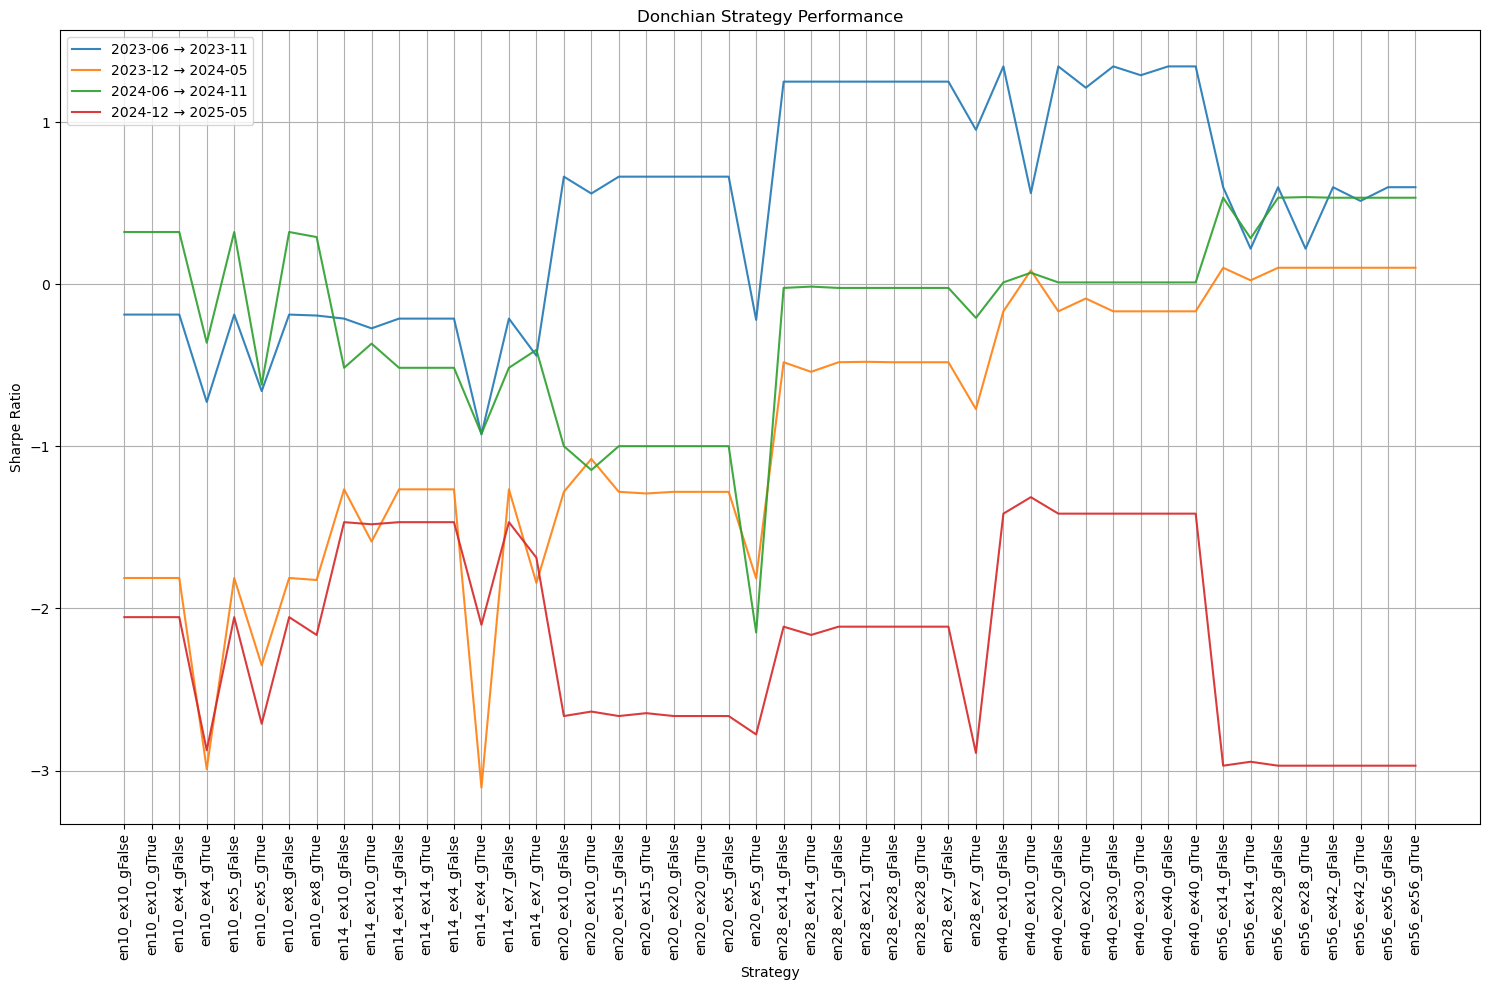

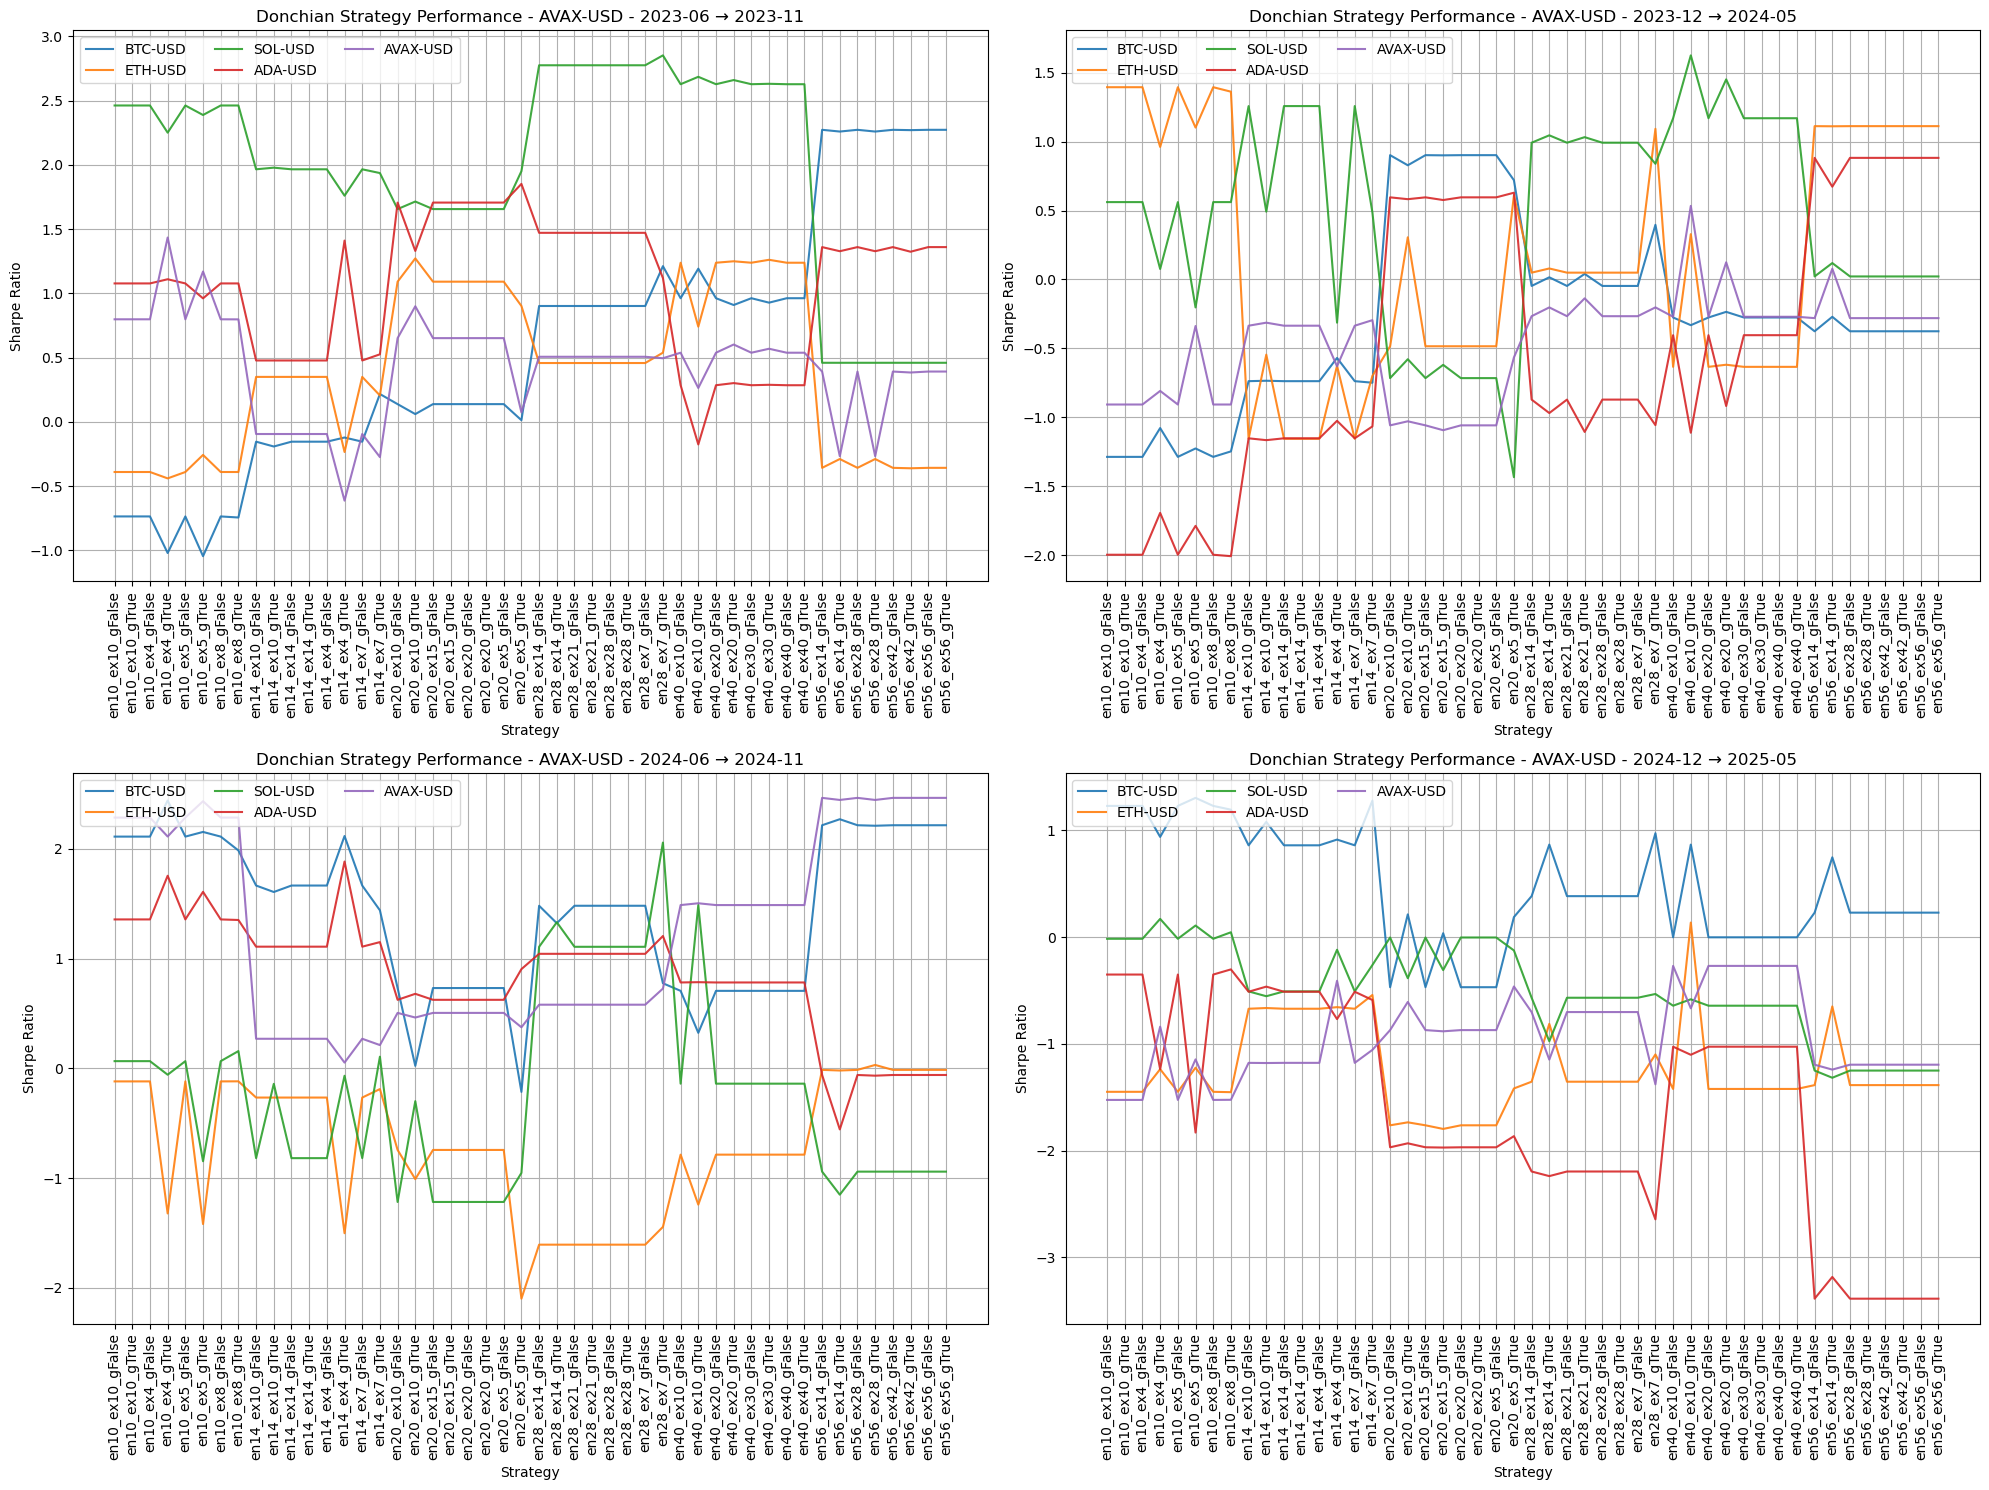

In [249]:
plot_donchian_channel_performance(df_donchian_results_os, ticker_list)

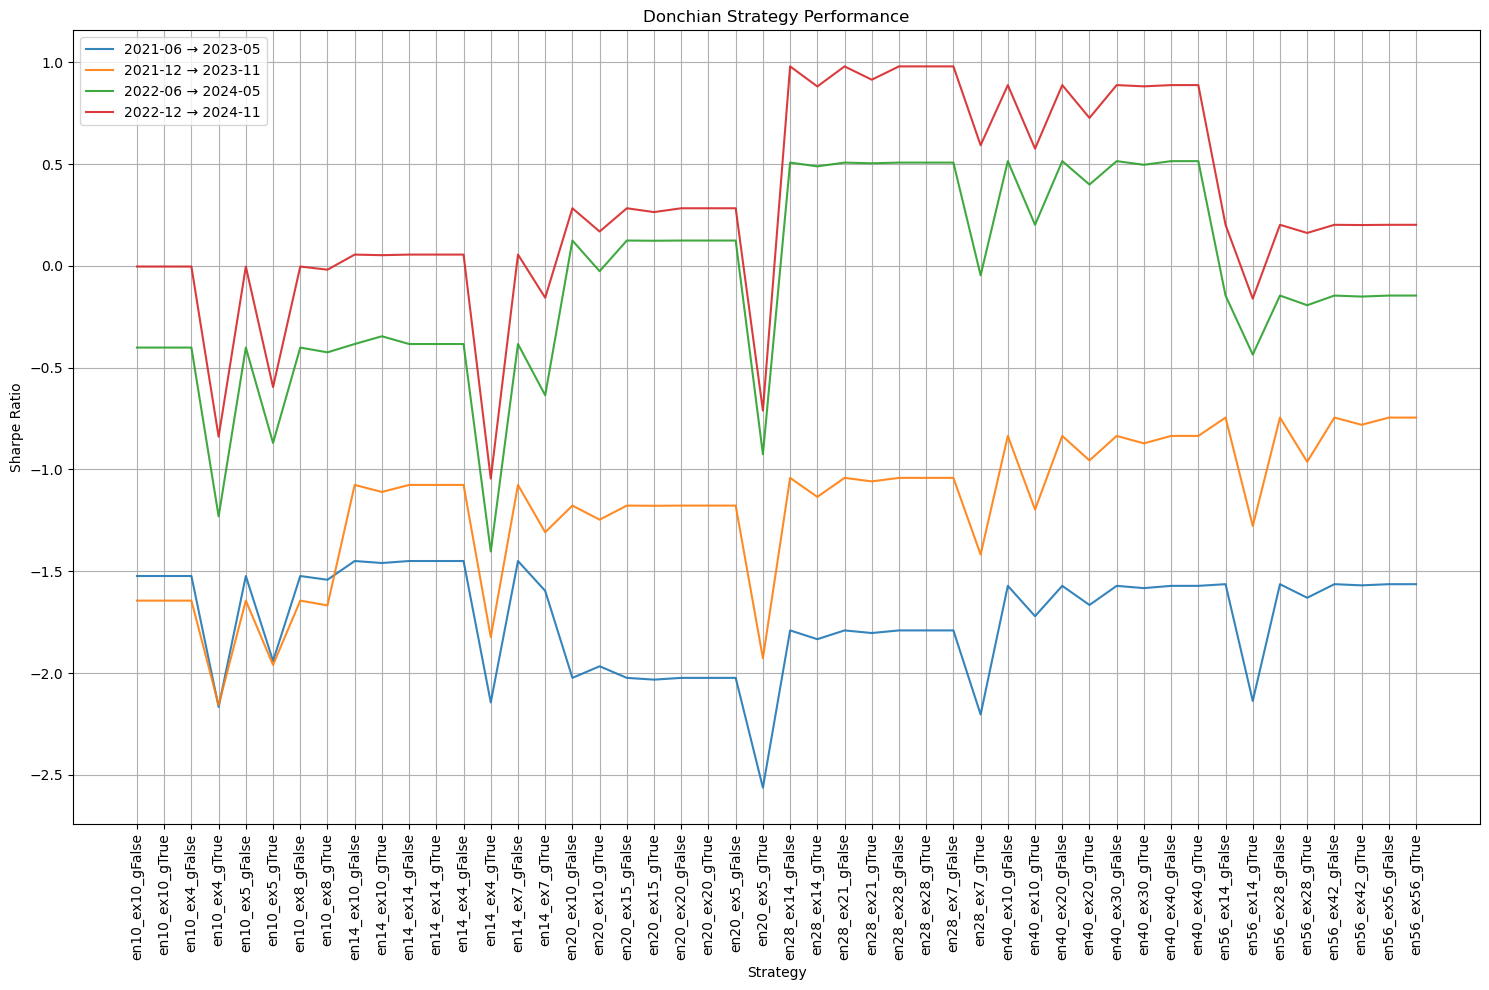

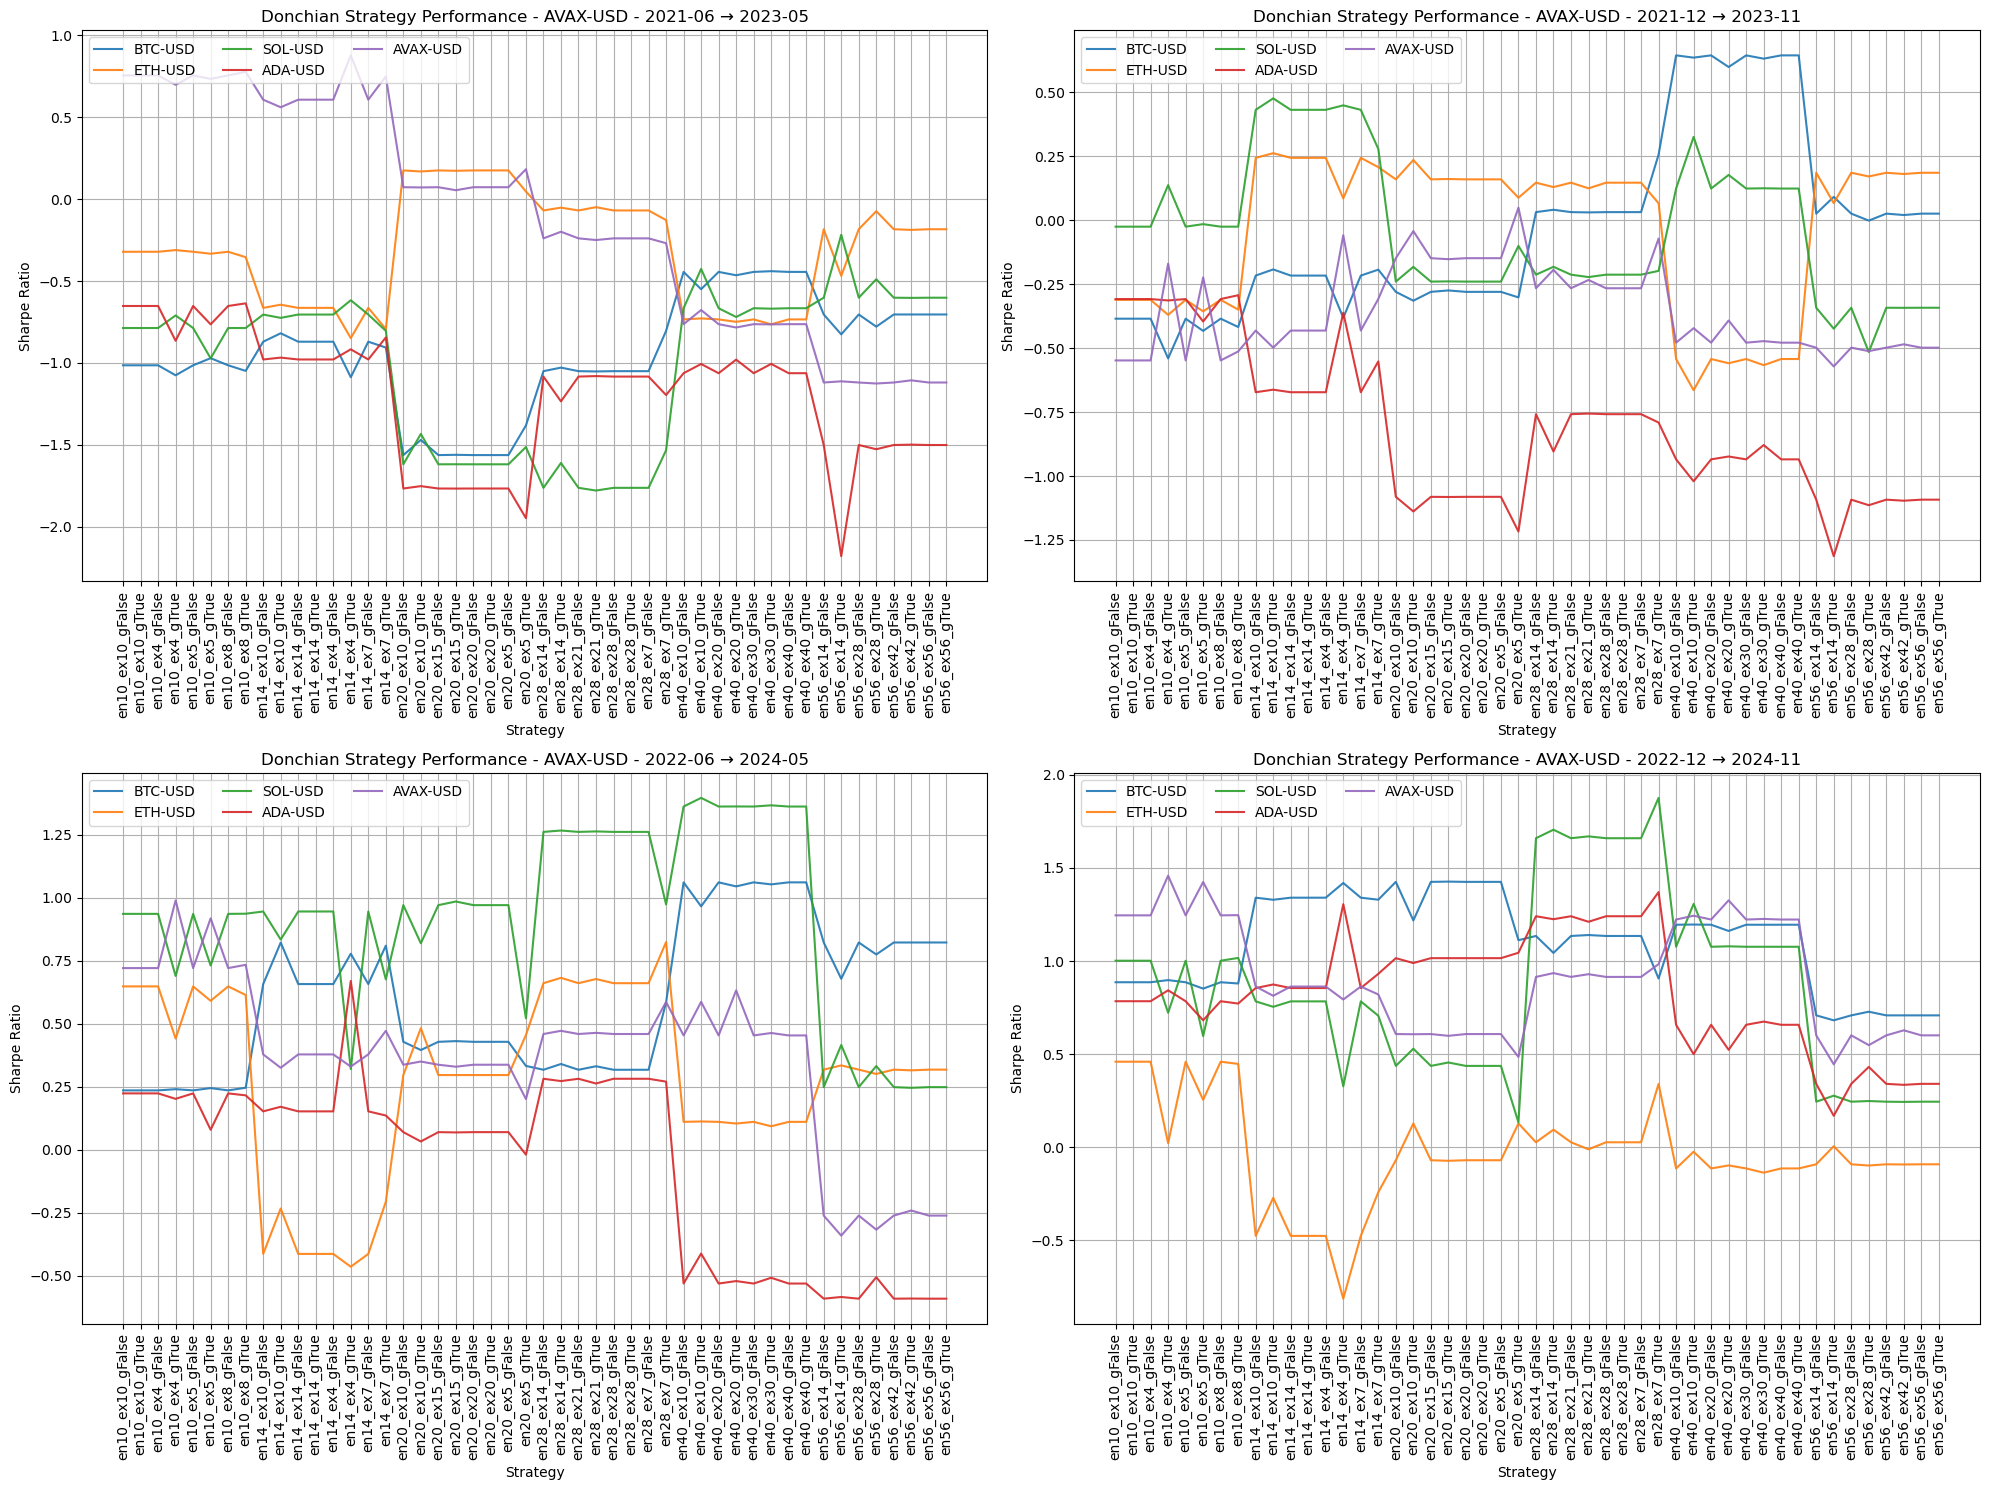

In [251]:
plot_donchian_channel_performance(df_donchian_results_is, ticker_list)

In [265]:
## Generate Trend Signal for all tickers
df_trend_ada_os = get_trend_donchian_signal_for_portfolio(start_date=pd.Timestamp('2024-12-01').date(), end_date=pd.Timestamp('2025-05-31').date(), ticker_list=['ADA-USD'], fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=40, 
                                                          exit_rolling_donchian_window=10, use_donchian_exit_gate=True,
                                                          donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [259]:
df_ada_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2024-12-01').date(), end_date=pd.Timestamp('2025-05-31').date(), ticker_list=['ADA-USD'], fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
    entry_rolling_donchian_window=40, exit_rolling_donchian_window=10, 
    use_donchian_exit_gate=True, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [287]:
df_ada_os.groupby(['ADA-USD_event']).size()

ADA-USD_event
Add Long Position      11
Close Long Position     5
New Long Position       6
No Position            89
Open Long Position     41
Stop-Loss Cooldown      2
Trim Long Position      6
dtype: int64

In [285]:
df_ada_os.head(200)

ADA-USD_20_avg_true_range_price  ADA-USD_actual_position_notional  \
date                                                                            
2024-12-22                         0.118550                          0.000000   
2024-12-23                         0.113574                          0.000000   
2024-12-24                         0.110376                          0.000000   
2024-12-25                         0.105503                          0.000000   
2024-12-26                         0.099293                          0.000000   
2024-12-27                         0.097208                          0.000000   
2024-12-28                         0.093607                          0.000000   
2024-12-29                         0.087854                          0.000000   
2024-12-30                         0.085258                          0.000000   
2024-12-31                         0.084291                          0.000000   
2025-01-01                         0.079987                          0.000000   
2025-01-02                         0.081569                          0.000000   
2025-01-03                         0.079601                          0.000000   
2025-01-04                         0.087496                          0.000000   
2025-01-05                         0.084706                          0.000000   
2025-01-06                         0.082381                          0.000000   
2025-01-07                         0.079650                          0.000000   
2025-01-08                         0.087702                          0.000000   
2025-01-09                         0.090293                          0.000000   
2025-01-10                         0.089665                          0.000000   
2025-01-11                         0.087792                          0.000000   
2025-01-12                         0.089269                       9051.683373   
2025-01-13                         0.087929                       8798.756649   
2025-01-14                         0.090593                       8587.681109   
2025-01-15                         0.088870                       9068.969732   
2025-01-16                         0.090654                       8959.982139   
2025-01-17                         0.093248                       9076.616031   
2025-01-18                         0.092110                       9444.845887   
2025-01-19                         0.092576                       9190.750624   
2025-01-20                         0.101721                       8262.678090   
2025-01-21                         0.105357                       8401.805660   
2025-01-22                         0.102819                       8381.811279   
2025-01-23                         0.097322                       8701.840969   
2025-01-24                         0.093900                      10205.443404   
2025-01-25                         0.089339                      10043.058219   
2025-01-26                         0.083440                      10098.910449   
2025-01-27                         0.080131                       9853.781221   
2025-01-28                         0.082271                      11114.995517   
2025-01-29                         0.080683                      10896.121461   
2025-01-30                         0.081152                      11179.230294   
2025-01-31                         0.078375                      11419.515942   
2025-02-01                         0.075616                      12675.803037   
2025-02-02                         0.075100                          0.000000   
2025-02-03                         0.083090                          0.000000   
2025-02-04                         0.100977                          0.000000   
2025-02-05                         0.101389                          0.000000   
2025-02-06                         0.096628                          0.000000   
2025-02-07                         0.093844

In [269]:
df_trend_ada_os.head(200)

ADA-USD_close  ADA-USD_open  ADA-USD_mavg_ribbon_slope  \
date                                                                 
2024-12-01         1.1503        1.0796                        NaN   
2024-12-02         1.2024        1.1505               1.492622e-15   
2024-12-03         1.1920        1.2028               1.867292e-03   
2024-12-04         1.1887        1.1930               3.204300e-03   
2024-12-05         1.1612        1.1886               4.303543e-03   
2024-12-06         1.2292        1.1614               4.313666e-03   
2024-12-07         1.2111        1.2298               6.714017e-03   
2024-12-08         1.1946        1.2110               8.270222e-03   
2024-12-09         1.0040        1.1944               9.099160e-03   
2024-12-10         1.0223        1.0045               2.512950e-03   
2024-12-11         1.0873        1.0222              -2.749668e-03   
2024-12-12         1.1230        1.0874              -4.955925e-03   
2024-12-13         1.1212        1.1232              -5.601450e-03   
2024-12-14         1.0609        1.1213              -6.248823e-03   
2024-12-15         1.0989        1.0607              -9.159445e-03   
2024-12-16         1.0781        1.0990              -1.031939e-02   
2024-12-17         1.0523        1.0779              -1.216623e-02   
2024-12-18         0.9678        1.0524              -1.485299e-02   
2024-12-19         0.8799        0.9677              -2.081008e-02   
2024-12-20         0.9498        0.8801              -3.023035e-02   
2024-12-21         0.9047        0.9495              -3.556242e-02   
2024-12-22         0.8824        0.9047              -4.242145e-02   
2024-12-23         0.9252        0.8824              -4.966488e-02   
2024-12-24         0.9352        0.9251              -5.419772e-02   
2024-12-25         0.9169        0.9351              -5.778838e-02   
2024-12-26         0.8601        0.9169              -6.179761e-02   
2024-12-27         0.8758        0.8601              -6.804475e-02   
2024-12-28         0.8881        0.8758              -7.286755e-02   
2024-12-29         0.8572        0.8880              -7.655440e-02   
2024-12-30         0.8598        0.8573              -8.127702e-02   
2024-12-31         0.8434        0.8600              -8.531719e-02   
2025-01-01         0.9206        0.8433              -8.966574e-02   
2025-01-02         0.9601        0.9204              -8.978434e-02   
2025-01-03         1.0889        0.9606              -8.795782e-02   
2025-01-04         1.0703        1.0888              -8.082126e-02   
2025-01-05         1.0909        1.0703              -7.487750e-02   
2025-01-06         1.0940        1.0908              -6.850485e-02   
2025-01-07         0.9891        1.0940              -6.243585e-02   
2025-01-08         0.9467        0.9891              -6.102423e-02   
2025-01-09         0.9042        0.9466              -6.146954e-02   
2025-01-10         0.9303        0.9042              -6.370048e-02   
2025-01-11         0.9949        0.9302              -6.442355e-02   
2025-01-12         0.9672        0.9949              -6.213672e-02   
2025-01-13         0.9438        0.9671              -6.112350e-02   
2025-01-14         0.9969        0.9439              -6.111824e-02   
2025-01-15         1.0757        0.9968              -5.869445e-02   
2025-01-16         1.0891        1.0755              -5.316511e-02   
2025-01-17         1.1337        1.0895              -4.749259e-02   
2025-01-18         1.1033        1.1337              -4.052961e-02   
2025-01-19         0.9918        1.1032              -3.523755e-02   
2025-01-20         1.0082        0.9918              -3.482759e-02   
2025-01-21         1.0061        1.0085              -3.369793e-02   
2025-01-22         0.9821        1.0061              -3.269182e-02   
2025-01-23         0.9864        0.9822              -3.273033e-02   
2025-01-24         0.9714        0.9867              -3.252156e-02   
2025-01-25         0.9